# Data Visualization

In [2]:
!pip install pymongo sentence-transformers xgboost lightgbm
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 28.0 MB/s eta 0:00:00


In [3]:
!pip install fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.6 MB/s eta 0:00:00


In [4]:
!pip install geohash2


  Preparing metadata (setup.py) ... done
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15543 sha256=bb9ea964c02786d27aa20e6fd484a5a15a64d55429efc8a45d11f78a1df02375
  Stored in directory: /root/.cache/pip/wheels/00/d5/b6/3fbe4088f7912982f596eaddfd593d16096468a2f13e470ae7
Successfully built geohash2


In [5]:
!pip install sentence-transformers

In [6]:
pip install rapidfuzz

In [7]:

import os
import re
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
from typing import Dict, List, Tuple, Optional


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, BallTree
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb  # Fixed import
import lightgbm as lgb  # Fixed import
import faiss

import torch
import torch.nn as nn
import torch.optim as optim  # Added missing import
from torch.utils.data import TensorDataset, DataLoader, random_split

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity  # Added import

import geohash2

from pymongo import MongoClient



In [8]:

# ============================ #
#      2. Connect to MongoDB   #
# ============================ #

username = "salma"
password = "f3ekNjEhzec0cYkx"
cluster = "production.g8vjv.mongodb.net"
uri = f"mongodb+srv://{username}:{password}@{cluster}/?retryWrites=true&w=majority"

client = MongoClient(uri)
db = client["heroku_v801wdr2"]
collection = db["addresses"]




In [9]:
# Query to fetch area field
print("🔄 Fetching areas from MongoDB collection...")
cursor = collection.find(
    {
        "deleted": False,
        "country": {"$regex": "^kuwait$", "$options": "i"},
        "area": {"$exists": True}  # Ensure area field exists
    },
    {"_id": 0, "area": 1}
)

# Process in chunks to handle large data
chunk_size = 10000
chunks = []
chunk = []

for doc in tqdm(cursor, desc="Loading areas"):
    chunk.append(doc)
    if len(chunk) >= chunk_size:
        chunks.append(pd.DataFrame(chunk))
        chunk = []

if chunk:
    chunks.append(pd.DataFrame(chunk))

if not chunks:
    print("❌ No data found in collection")
else:
    df = pd.concat(chunks, ignore_index=True)
    print(f"📊 Loaded {len(df)} records with area field")

    # Clean and count unique areas
    df['area'] = df['area'].apply(str).str.strip()  # Convert to string and remove whitespace
    area_counts = df['area'].value_counts()

    # Print unique areas and their counts
    print("\n📝 Unique areas and their counts:")
    print("-------------------------------------")
    for area, count in area_counts.items():
        print(f"Area: {area or 'None/Empty'} | Count: {count}")
    print("-------------------------------------")
    print(f"Total unique areas: {len(area_counts)}")

    # Check for problematic areas
    invalid_areas = df[df['area'].isin(['', 'nan', 'null', 'none', None])]['area'].value_counts()
    if not invalid_areas.empty:
        print("\n⚠️ Problematic areas found:")
        print(invalid_areas.to_dict())


🔄 Fetching areas from MongoDB collection...


Loading areas: 136750it [00:07, 19271.46it/s]


📊 Loaded 136750 records with area field

📝 Unique areas and their counts:
-------------------------------------
Area: Sabah Al-Salem | Count: 5609
Area: Abdullah Mubarak Al-Sabah | Count: 4977
Area: Salmiya | Count: 4483
Area: Salwa | Count: 4217
Area: Jabriya | Count: 3930
Area: Mishrif | Count: 3757
Area: Zahra | Count: 3665
Area: Bayan | Count: 3319
Area: Qortuba | Count: 3294
Area: Surra | Count: 3121
Area: Salam | Count: 3076
Area: Al-Adan | Count: 3015
Area: Hitteen | Count: 2921
Area: Mubarak Al-Kabeer | Count: 2840
Area: Rumaithiya | Count: 2487
Area: Jaber Al-Ahmad | Count: 2371
Area: Shuhada | Count: 2236
Area: Mangaf | Count: 2223
Area: Abu Ftaira | Count: 2167
Area: Yarmouk | Count: 2150
Area: Saad Al-Abdulla City | Count: 2119
Area: Andalus | Count: 2011
Area: Sabahiya | Count: 1967
Area: Al-Fnaitees | Count: 1917
Area: Mahboula | Count: 1829
Area: Sulaibiya | Count: 1735
Area: Al-Fintas | Count: 1704
Area: Rawda | Count: 1653
Area: Kaerawan | Count: 1649
Area: Abdulla Al-

In [40]:
# Fetch full dataset for EDA (adjust projection to include relevant fields)
print("🔄 Fetching full dataset from MongoDB for EDA...")
cursor = collection.find(
    {
        "deleted": False,
        "country": {"$regex": "^kuwait$", "$options": "i"},
        "area": {"$exists": True}  # Filter for records with area
    },
    {
        "_id": 0,
        "area": 1,
        "governorate": 1,  # Assuming this field exists; add more as needed
        "street": 1,
        "building": 1,
        "lat": 1,  # Latitude for geospatial EDA
        "lng": 1,  # Longitude
        "block": 1,  # Common in Kuwait addresses
        "street_number": 1
    }
)

# Process in chunks
chunk_size = 10000
chunks = []
chunk = []

for doc in tqdm(cursor, desc="Loading full data"):
    chunk.append(doc)
    if len(chunk) >= chunk_size:
        chunks.append(pd.DataFrame(chunk))
        chunk = []

if chunk:
    chunks.append(pd.DataFrame(chunk))

if not chunks:
    print("❌ No data found")
else:
    df_full = pd.concat(chunks, ignore_index=True)
    print(f"📊 Full dataset shape: {df_full.shape}")

    # Basic info
    print("\n📋 Data Types and Non-Null Counts:")
    print(df_full.info())

    # Missing values
    print("\n🔍 Missing Values per Column:")
    missing = df_full.isnull().sum()
    missing_pct = (missing / len(df_full)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
    print(missing_df[missing_df['Missing Count'] > 0])

    # Statistical summary for numerical fields
    print("\n📈 Numerical Summary:")
    print(df_full.describe())

    # Categorical summary
    print("\n🏷️ Categorical Summary (Top 10 unique values per column):")
    for col in df_full.select_dtypes(include=['object']).columns:
        print(f"\n{col}: {df_full[col].nunique()} unique values")
        print(df_full[col].value_counts().head(10))

    # Duplicates
    duplicates = df_full.duplicated().sum()
    print(f"\n🔄 Duplicate rows: {duplicates}")

    # Save for later use (optional)
    df_full.to_pickle('full_addresses_eda.pkl')  # Quick save for reuse

🔄 Fetching full dataset from MongoDB for EDA...


Loading full data: 136750it [00:05, 24267.56it/s]


📊 Full dataset shape: (136750, 3)

📋 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136750 entries, 0 to 136749
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   area    136750 non-null  object
 1   block   136750 non-null  object
 2   street  136750 non-null  object
dtypes: object(3)
memory usage: 3.1+ MB
None

🔍 Missing Values per Column:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

📈 Numerical Summary:
                  area   block  street
count           136750  136750  136750
unique             159      37   12038
top     Sabah Al-Salem       1    St 1
freq              5609   26529    7779

🏷️ Categorical Summary (Top 10 unique values per column):

area: 159 unique values
area
Sabah Al-Salem               5609
Abdullah Mubarak Al-Sabah    4977
Salmiya                      4483
Salwa                        4217
Jabriya                      3930
Mishrif                

In [42]:
import seaborn as sns
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
%matplotlib inline

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)  # Default figure size

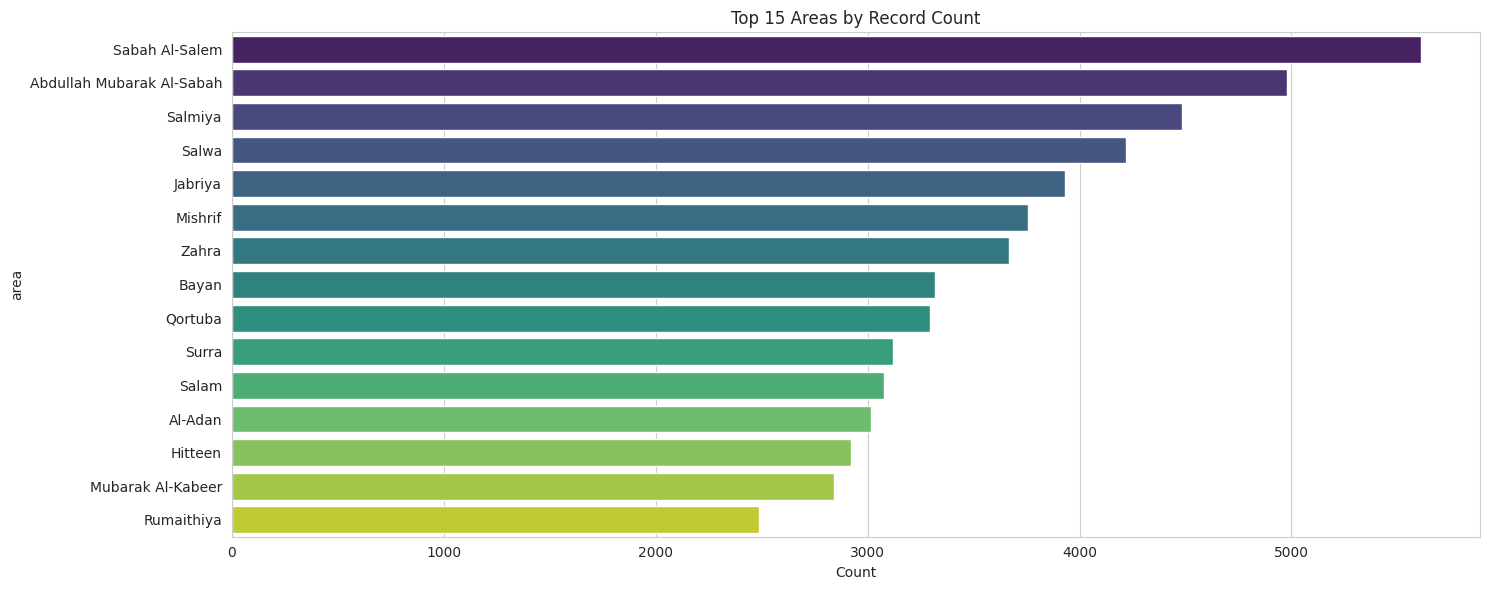

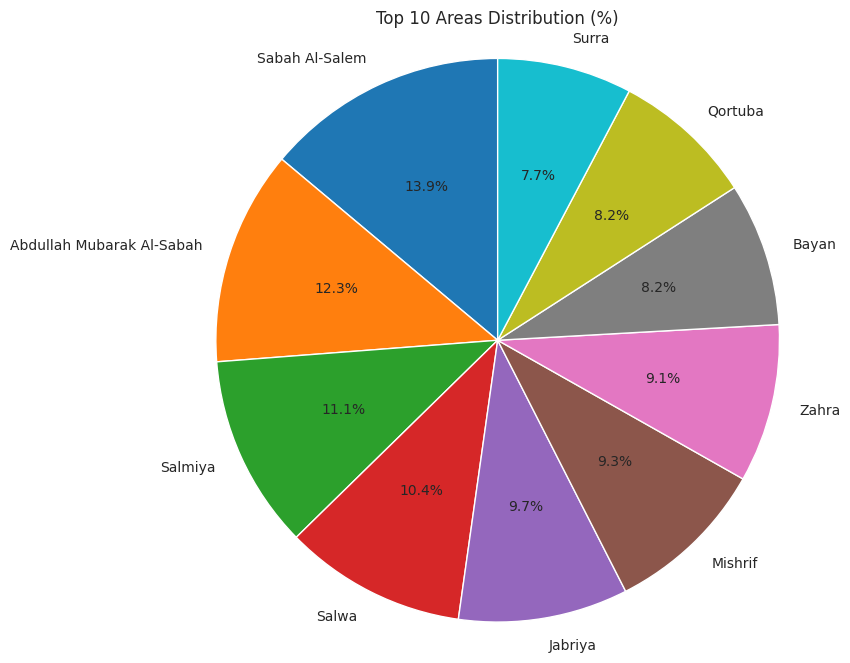

In [43]:
# Visualize top areas by count
plt.figure(figsize=(15, 6))
top_areas = df_full['area'].value_counts().head(15)  # Top 15 areas
sns.barplot(x=top_areas.values, y=top_areas.index, palette='viridis')
plt.title('Top 15 Areas by Record Count')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# If governorate field exists, visualize it
if 'governorate' in df_full.columns:
    plt.figure(figsize=(10, 6))
    gov_counts = df_full['governorate'].value_counts()
    sns.barplot(x=gov_counts.values, y=gov_counts.index, palette='plasma')
    plt.title('Governorate Distribution')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

# Pie chart for area distribution (top 10)
plt.figure(figsize=(8, 8))
top_areas_pie = df_full['area'].value_counts().head(10)
plt.pie(top_areas_pie.values, labels=top_areas_pie.index, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Areas Distribution (%)')
plt.axis('equal')
plt.show()

🔍 Available columns in df_full: ['area', 'block', 'street', 'lat', 'lng']
⚠️ No location.latitude/location.longitude fields found. Generating sample data based on Kuwait areas.
📊 Generated sample with 1000 points across top areas: ['Sabah Al-Salem', 'Abdullah Mubarak Al-Sabah', 'Salmiya', 'Salwa', 'Jabriya']


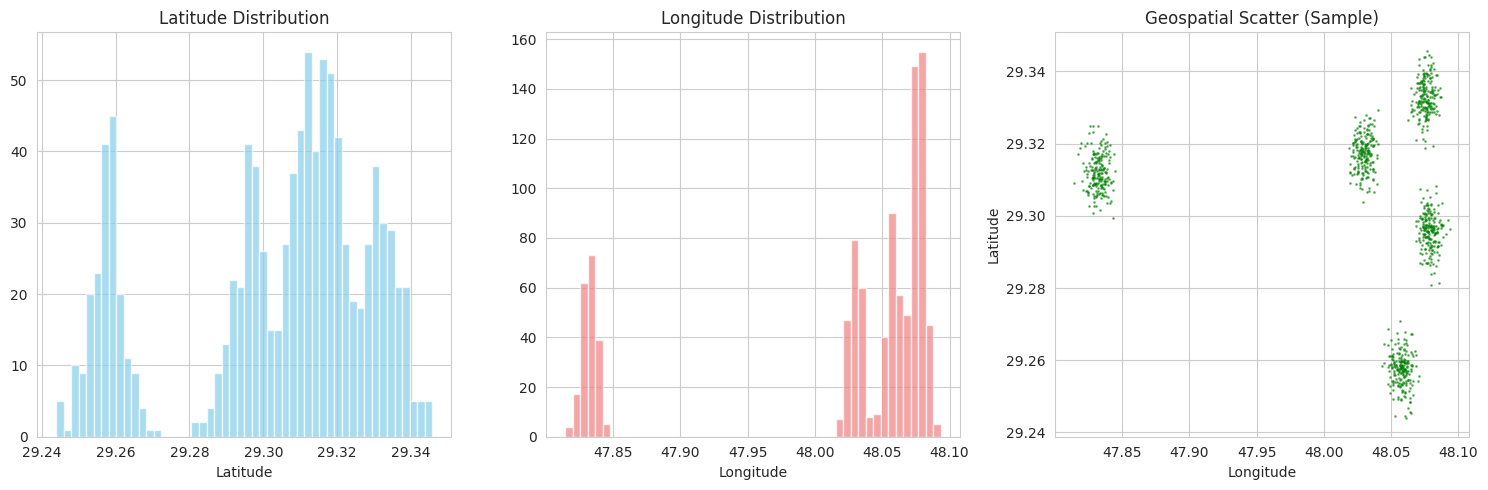

🗺️ Interactive map saved as 'kuwait_addresses_map.html'. Open in browser for zoom/popup exploration.


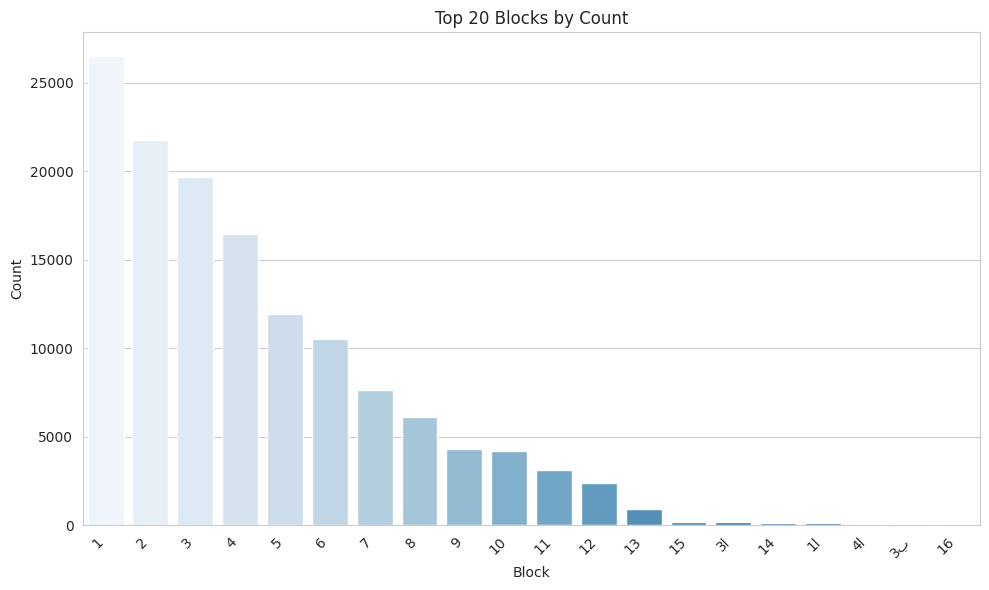

📈 Visualized top blocks from real data.


In [50]:
# Enhanced Geospatial Visualizations (handling nested location fields)
import numpy as np  # Ensure imported for random sampling
import seaborn as sns  # For better styling
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

# Debug: Print available columns to diagnose missing fields
print("🔍 Available columns in df_full:", list(df_full.columns))

# Check for location.latitude and location.longitude
has_coords = 'location.latitude' in df_full.columns and 'location.longitude' in df_full.columns

if has_coords:
    print("✅ location.latitude/location.longitude found. Using real data.")
    # Use full data for histograms
    lat_data = df_full['location.latitude']
    lng_data = df_full['location.longitude']
    # Sample for scatter/map to avoid performance issues
    sample_df = df_full.dropna(subset=['location.latitude', 'location.longitude']).sample(
        min(1000, len(df_full)), random_state=42
    )
    print(f"📊 Using {len(sample_df)} points after dropping NaN coordinates.")
else:
    print("⚠️ No location.latitude/location.longitude fields found. Generating sample data based on Kuwait areas.")
    # Sample data generation: Use top areas from df_full and assign approximate coordinates
    area_coords = {
        'Sabah Al-Salem': (29.257, 48.057),  # Approx center
        'Abdullah Mubarak Al-Sabah': (29.312, 47.832),
        'Salmiya': (29.333, 48.076),
        'Salwa': (29.296, 48.079),
        'Jabriya': (29.317, 48.029),
        # Add more areas as needed from your 159 unique areas
    }

    top_areas = df_full['area'].value_counts().head(5).index.tolist()  # Top 5 areas
    sample_data = []
    np.random.seed(42)  # For reproducibility

    for area in top_areas:
        if area in area_coords:
            base_lat, base_lng = area_coords[area]
            # Generate 200 points per area with small noise (±0.005 degrees ~500m)
            for _ in range(200):
                noise = np.random.normal(0, 0.005, 2)
                sample_data.append({
                    'area': area,
                    'location.latitude': base_lat + noise[0],
                    'location.longitude': base_lng + noise[1],
                    'block': np.random.choice(['1', '2', '3', '4', '1A', '2B']),  # Kuwait-style blocks
                    'street': f"Sample Street {np.random.randint(1, 100)}"
                })
        else:
            # Fallback to Kuwait City center
            sample_data.append({
                'area': area,
                'location.latitude': 29.3786 + np.random.normal(0, 0.005),
                'location.longitude': 47.9903 + np.random.normal(0, 0.005),
                'block': np.random.choice(['1', '2', '3', '4', '1A', '2B']),
                'street': f"Sample Street {np.random.randint(1, 100)}"
            })

    sample_df = pd.DataFrame(sample_data)
    lat_data = sample_df['location.latitude']
    lng_data = sample_df['location.longitude']
    df_full_sample = sample_df  # For block viz if needed
    print(f"📊 Generated sample with {len(sample_df)} points across top areas: {top_areas}")

# Validate coordinate ranges (Kuwait: ~28.5–30.1°N, ~46.5–48.6°E)
if has_coords:
    lat_min, lat_max = lat_data.min(), lat_data.max()
    lng_min, lng_max = lng_data.min(), lng_data.max()
    print(f"📍 Latitude range: {lat_min:.4f} to {lat_max:.4f}")
    print(f"📍 Longitude range: {lng_min:.4f} to {lng_max:.4f}")
    if not (28.5 <= lat_min <= lat_max <= 30.1 and 46.5 <= lng_min <= lng_max <= 48.6):
        print("⚠️ Warning: Some coordinates are outside expected Kuwait ranges.")

# Histograms and Scatter Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
lat_data.hist(bins=50, alpha=0.7, color='skyblue')
plt.title('Latitude Distribution')
plt.xlabel('Latitude')

plt.subplot(1, 3, 2)
lng_data.hist(bins=50, alpha=0.7, color='lightcoral')
plt.title('Longitude Distribution')
plt.xlabel('Longitude')

plt.subplot(1, 3, 3)
plt.scatter(
    sample_df['location.longitude'],
    sample_df['location.latitude'],
    alpha=0.5,
    s=1,
    c='green'
)
plt.title('Geospatial Scatter (Sample)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Interactive Folium Map
if len(sample_df) > 0:
    kuwait_center = [29.3117, 47.4818]  # Approx Kuwait center
    m = folium.Map(location=kuwait_center, zoom_start=8)

    # Color-code markers by area
    unique_areas = sample_df['area'].unique()
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

    for idx, row in sample_df.iterrows():
        lat, lng = row['location.latitude'], row['location.longitude']
        # Skip invalid coordinates
        if not (28.5 <= lat <= 30.1 and 46.5 <= lng <= 48.6):
            continue
        area = row.get('area', 'N/A')
        color_idx = list(unique_areas).index(area) % len(colors)
        folium.CircleMarker(
            location=[lat, lng],
            radius=3,
            popup=f"Area: {area}<br>Block: {row.get('block', 'N/A')}<br>Street: {row.get('street', 'N/A')}",
            color=colors[color_idx],
            fill=True,
            fillColor=colors[color_idx],
            fillOpacity=0.6
        ).add_to(m)

    # Heatmap overlay (only valid coordinates)
    heat_data = [
        [row['location.latitude'], row['location.longitude']]
        for _, row in sample_df.iterrows()
        if 28.5 <= row['location.latitude'] <= 30.1 and 46.5 <= row['location.longitude'] <= 48.6
    ]
    if heat_data:
        HeatMap(heat_data, radius=15).add_to(m)
        m.save('kuwait_addresses_map.html')
        print("🗺️ Interactive map saved as 'kuwait_addresses_map.html'. Open in browser for zoom/popup exploration.")
    else:
        print("❌ No valid coordinates for heatmap. Map may be incomplete.")
else:
    print("❌ No data available for map.")

# Block Visualization
block_df = df_full if 'block' in df_full.columns else sample_df
if 'block' in block_df.columns:
    plt.figure(figsize=(10, 6))
    top_blocks = block_df['block'].value_counts().head(20)
    sns.barplot(x=top_blocks.index, y=top_blocks.values, palette='Blues')  # Fixed palette
    plt.title('Top 20 Blocks by Count')
    plt.xlabel('Block')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"📈 Visualized top blocks from {'real' if 'block' in df_full.columns else 'sample'} data.")
else:
    print("⚠️ No 'block' field found in data (real or sample). Skipping block viz.")

#Data preparation

In [10]:
import re
import pandas as pd
from typing import Dict, Tuple, Optional

# Comprehensive KUWAIT_GOVERNORATES with all relevant areas
KUWAIT_GOVERNORATES = {
    "ahmadi": set([
        "ahmadi", "fahaheel", "mangaf", "mahboula", "abu halifa", "fintas", "al wafra",
        "eqaila", "ali sabah al salem", "hadiya", "riqqah", "sabah al ahmad", "khiran",
        "wafra farms", "fintan", "south fahaheel", "al mahboula industrial",
        "jaber al ali", "fahad al ahmad", "al julayah", "al zour", "bnaider", "nuwaiseeb",
        "riqqa", "east ahmadi", "north ahmadi", "south ahmadi", "middle of ahmadi",
        "mina al-ahmadi refinery", "shalehat al-khiran", "shalehat bneder", "shalehat zoor",
        "new wafra", "ahmadi governorate desert", "shalehat mina abdullah", "mina abdulla",
        "sabahiya", "south sabahiya", "mina abdulla refinery", "shuaiba industrial western",
        "shuaiba industrial easterly", "sabah al-ahmad 1", "sabah al-ahmad 2",
        "sabah al-ahmad 3", "sabah al-ahmad 4", "sabah al-ahmad 5",
        "أحمدي", "الفحيحيل", "المنقف", "المهبولة", "أبو حليفة", "الفنطاس", "الوفرة",
        "العقيلة", "علي صباح السالم", "هدية", "الرقة", "صباح الأحمد", "خيران",
        "مزارع الوفرة", "فنطان", "جنوب الفحيحيل", "المهبولة الصناعية",
        "جابر العلي", "فهد الأحمد", "الجليعة", "الزور", "بنيدر", "نويصيب",
        "شرق الأحمدي", "شمال الأحمدي", "جنوب الأحمدي", "وسط الأحمدي",
        "مصفاة ميناء الأحمدي", "شاليهات الخيران", "شاليهات بنيدر", "شاليهات الزور",
        "الوفرة الجديدة", "صحراء محافظة الأحمدي", "شاليهات ميناء عبدالله", "ميناء عبدالله",
        "صباحية", "جنوب صباحية", "مصفاة ميناء عبدالله", "الشعيبة الصناعية الغربية",
        "الشعيبة الصناعية الشرقية", "صباح الأحمد 1", "صباح الأحمد 2",
        "صباح الأحمد 3", "صباح الأحمد 4", "صباح الأحمد 5"
    ]),
    "farwaniya": set([
        "farwaniya", "khaitan", "abraq khaitan", "andalous", "jleeb al shuyoukh", "omariya",
        "rabiya", "ardiya", "firdous", "south surra", "riggae", "ardiya industrial",
        "west khaitan", "al rai", "ferdous cooperative", "abdullah al mubarak", "sabah al nasser",
        "ardhiya", "ferdous", "rai", "rehab", "ashbeliah", "ardhiya 6", "ardhiya herafiya",
        "ardhiya 4", "dajeej", "amghara industrial", "sulaibiya industrial 2",
        "sulaibiya industrial 1", "sulaibiya agricultural", "mubarakiya camps",
        "فراونية", "خيطان", "عبرق خيطان", "اندلس", "جليب الشيوخ", "عمرية",
        "الرابية", "العارضية", "الفردوس", "جنوب السرة", "الرقعي",
        "العارضية الصناعية", "غرب خيطان", "الرأي", "تعاونية الفردوس",
        "عبدالله المبارك", "صباح الناصر", "الرحاب", "الأشبيلية", "العارضية 6",
        "العارضية الحرفية", "العارضية 4", "الدجيج", "أمغارة الصناعية",
        "الصليبية الصناعية 2", "الصليبية الصناعية 1", "الصليبية الزراعية",
        "مخيمات المباركية"
    ]),
    "jahra": set([
        "jahra", "sulaibiya", "taima", "qasr", "doha", "naeem", "al oyoun", "abdali",
        "kabd", "al mutlaa", "subiya", "amghara", "sulaibiya industrial", "jahra farms",
        "al waha", "nesaem", "al salmi", "jahra industrial", "qairawan", "al rawdatain",
        "oyoun", "waha", "saad al-abdulla city", "north west jahra", "jawakher al jahra",
        "bar al-jahra governorate", "jahra camps", "rawdatain", "salmy", "shalehat doha",
        "shalehat subiya", "mina doha", "shalehat al-nuwaiseeb",
        "الجهراء", "الصليبية", "تيماء", "القصر", "الدوحة", "النعيم", "العيون",
        "عبدلي", "كبد", "المطلع", "الصبية", "أمغارة", "الصليبية الصناعية",
        "مزارع الجهراء", "الواحة", "النسيم", "السالمي", "الجهراء الصناعية",
        "قيروان", "الروضتين", "مدينة سعد العبدالله", "شمال غرب الجهراء",
        "جواخير الجهراء", "بار محافظة الجهراء", "مخيمات الجهراء", "الروضتين",
        "السالمي", "شاليهات الدوحة", "شاليهات الصبية", "ميناء الدوحة", "شاليهات النويصيب"
    ]),
    "capital": set([
        "kuwait city", "dasman", "qibla", "mirqab", "sharq", "bneid al gar", "daiya",
        "shuwaih", "sulaibikhat", "yarmouk", "kaifan", "shamiya", "rawda",
        "shuwaih industrial", "shuwaih port", "al muthanna", "nuzha", "faiha",
        "abdullah as salim", "adiliya", "khaldiya", "qadsiya", "qurtuba", "surra",
        "jaber al ahmad city", "nahdha", "ghirnata", "shuwaikh", "dasma",
        "jaber al ahmad", "mansouriya", "northwest sulaibikhat", "ministries area",
        "health area", "مدينة الكويت", "دسمان", "القبلة", "المرقاب", "شرق",
        "بنيد القار", "الدعية", "الشويخ", "الصليبيخات", "اليرموك", "كيفان",
        "الشامية", "الروضة", "الشويخ الصناعية", "ميناء الشويخ", "المثنى",
        "النزهة", "الفيحاء", "عبدالله السالم", "العديلية", "الخالدية", "القادسية",
        "قرطبة", "السرة", "جابر الأحمد", "النهضة", "غرناطة", "المنصورية",
        "شمال غرب الصليبيخات", "منطقة الوزارات", "المنطقة الصحية"
    ]),
    "hawalli": set([
        "hawalli", "salmiya", "jabriya", "bayan", "mishref", "salwa", "rumaithiya", "shaab",
        "hitteen", "al siddeeq", "salam", "maidan hawalli", "hawalli south", "surra",
        "zahra", "south jabriya", "mubarak al jabir", "al bedae", "north surra", "shuhada",
        "abu hassaniah", "حولي", "السالمية", "الجابرية", "بيان", "المشرف", "السلوى",
        "الرميثية", "الشعب", "حطين", "الصديق", "سلام", "ميدان حولي", "جنوب حولي",
        "السرة", "الزهراء", "جنوب الجابرية", "مبارك الجابر", "البدع", "شمال السرة",
        "الشهداء", "أبو حسانية"
    ]),
    "mubarak_al_kabeer": set([
        "mubarak al kabeer", "qurain", "adan", "abu ftaira", "funaitees", "sabah al salem",
        "al masayel", "messila", "al qusour", "west abu ftaira", "al zour",
        "sabah al ahmad sea city", "fintas al aqeelah", "qurain markets", "subhan",
        "mubarak al-abdullah", "west abu ftirah hirafyia", "sabah al-salem university city",
        "al sour gardens", "مبارك الكبير", "القرين", "العدان", "أبو فطيرة", "الفنيطيس",
        "صباح السالم", "المسايل", "المسيلة", "القصور", "غرب أبو فطيرة", "الزور",
        "مدينة صباح الأحمد البحرية", "فنطاس العقيلة", "أسواق القرين", "صبحان",
        "مبارك العبدالله", "غرب أبو فطيرة الحرفية", "مدينة صباح السالم الجامعية",
        "حدائق الصور"
    ])
}

# OPTIMIZED: Create a single set for all areas for faster lookup
ALL_KUWAIT_AREAS = set()
for gov_areas in KUWAIT_GOVERNORATES.values():
    ALL_KUWAIT_AREAS.update(gov_areas)

# Enhanced abbreviation map with Arabic equivalents (unchanged)
ABBREVIATION_MAP = {
    "st": "street", "rd": "road", "ave": "avenue", "blvd": "boulevard",
    "ln": "lane", "cr": "crescent", "blk": "block", "bldg": "building",
    "apt": "apartment", "flr": "floor", "mohd": "mohammed", "bn": "bin",
    "hwy": "highway",
    "gov": "governorate", "dist": "district", "sec": "section",
    "al": "al", "ibn": "bin", "abd": "abdul",
    "ش": "شارع", "ط": "طريق", "م": "مجمع", "ع": "عمارة",
    "ق": "قصر", "ح": "حي",
    "masjid": "mosque", "souq": "market", "hospital": "hospital"
}

# Comprehensive COMMON_TYPOS with additional typos for unmatched areas
COMMON_TYPOS = {
    "hawalia": "hawalli","al wafra": "wafra",
    "salmiyah": "salmiya",
    "jleeb": "jleeb al shuyoukh",
    "sharg": "sharq",
    "fintus": "fintas",
    "mubark": "mubarak al kabeer",
    "wafrah": "wafra",
    "alwafra": "wafra",
    "وفرة": "wafra",
    "jahrah": "jahra",
    "jehra": "jahra",
    "الجهراء": "jahra",
    # Expanded variations for major Kuwait places
    "hawally": "hawalli", "hawali": "hawalli", "hawaalli": "hawalli", "7awalli": "hawalli", "الحولي": "hawalli",
    "hawaley": "hawalli", "hawaly": "hawalli", "7awali": "hawalli",
    "salamiya": "salmiya", "salmeya": "salmiya", "salmiyya": "salmiya", "سالمية": "salmiya",
    "salamiyah": "salmiya", "salameya": "salmiya", "salmia": "salmiya", "salmya": "salmiya",
    "jabriyah": "jabriya", "jabria": "jabriya", "jabreya": "jabriya", "jabryah": "jabriya",
    "jabaryah": "jabriya", "جابرية": "jabriya", "jabariya": "jabriya", "jaabriya": "jabriya", "jabrya": "jabriya",
    "bayaan": "bayan", "byan": "bayan", "bayyan": "bayan", "البيان": "bayan", "bayn": "bayan",
    "mishrif": "mishref", "mishraf": "mishref", "المشرف": "mishref", "misharef": "mishref", "mshref": "mishref",
    "salwah": "salwa", "salva": "salwa", "السلوى": "salwa", "salwaa": "salwa",
    "rumathiya": "rumaithiya", "rumaithiyah": "rumaithiya", "rumaitiya": "rumaithiya", "رميثية": "rumaithiya",
    "romaithiya": "rumaithiya", "romathiya": "rumaithiya", "rumaithya": "rumaithiya",
    "sha'ab": "shaab", "shaeb": "shaab", "الشعب": "shaab", "شعب": "shaab", "sha3ab": "shaab", "shab": "shaab",
    "faheel": "fahaheel", "fahaeel": "fahaheel", "faha7eel": "fahaheel", "الفحيحيل": "fahaheel",
    "fahheel": "fahaheel", "fahaiheel": "fahaheel", "faha7il": "fahaheel", "fa7aheel": "fahaheel",
    "mangaaf": "mangaf", "mnqaf": "mangaf", "المنقف": "mangaf", "mangaph": "mangaf", "manqaf": "mangaf", "mangf": "mangaf",
    "mahbula": "mahboula", "mahboola": "mahboula", "ma7boula": "mahboula", "مهبولة": "mahboula",
    "mahboulah": "mahboula", "mahbola": "mahboula", "ma7bula": "mahboula",
    "abu khalifa": "abu halifa", "abo halifa": "abu halifa", "abou halifa": "abu halifa", "أبو خليفة": "abu halifa",
    "abu 7alifa": "abu halifa", "abu halifah": "abu halifa",
    "finitas": "fintas", "فنطاس": "fintas", "fintaas": "fintas", "fintass": "fintas",
    "al-zour": "al zour", "zour": "al zour", "zoor": "al zour", "al zour": "al zour", "alzour": "al zour", "الزور": "al zour",
    "kuwaicity": "kuwait city", "kuwaitcity": "kuwait city",
    "dasmaan": "dasman", "دسمان": "dasman", "dasma": "dasman",
    "qiblah": "qibla", "qeblah": "qibla", "قبلة": "qibla", "kibla": "qibla", "qebla": "qibla", "qibl": "qibla",
    "mirqaab": "mirqab", "morqab": "mirqab", "المرقاب": "mirqab", "merqab": "mirqab", "mirgab": "mirqab",
    "shark": "sharq", "شرق": "sharq", "shar9": "sharq", "shrq": "sharq",
    "farwaniyah": "farwaniya", "farwania": "farwaniya", "الفراونية": "farwaniya", "farwaniyyah": "farwaniya",
    "pharwaniya": "farwaniya", "farwaniah": "farwaniya", "farwaneya": "farwaniya", "farwanya": "farwaniya",
    "farvaniya": "farwaniya", "farwanea": "farwaniya", "ferwaniya": "farwaniya", "farawaniya": "farwaniya",
    "khaytaan": "khaitan", "khaytan": "khaitan", "7aitan": "khaitan", "الخيطان": "khaitan", "khaitaan": "khaitan",
    "khitan": "khaitan", "7itan": "khaitan", "kaytan": "khaitan", "kheitan": "khaitan", "khytan": "khaitan", "kaitan": "khaitan",
    "abraq khaytan": "abraq khaitan", "abrq khaitan": "abraq khaitan", "عبرق خيطان": "abraq khaitan", "abraq 7aitan": "abraq khaitan",
    "abraq kheitan": "abraq khaitan",
    "jaleeb al shuyookh": "jleeb al shuyoukh", "jleeb shuyoukh": "jleeb al shuyoukh", "جليب شيوخ": "jleeb al shuyoukh",
    "jleeb alshouyoukh": "jleeb al shuyoukh", "jaleeb": "jleeb al shuyoukh", "jleeb al-shuyoukh": "jleeb al shuyoukh",
    "jlib al shuyoukh": "jleeb al shuyoukh", "jleeb alshuyoukh": "jleeb al shuyoukh",
    "west jleeb al-shuyoukh": "jleeb al shuyoukh", "west jleeb al shuyoukh": "jleeb al shuyoukh", "jleeb shyoukh": "jleeb al shuyoukh",
    "al-siddeeq": "al siddeeq", "al siddiq": "al siddeeq", "alsiddiq": "al siddeeq", "siddeeq": "al siddeeq",
    "siddiq": "al siddeeq", "الصديق": "al siddeeq", "صديق": "al siddeeq",
    "jahrah": "jahra", "ja7ra": "jahra", "جهراء": "jahra", "jahara": "jahra", "jehra": "jahra",
    "sulaibiyah": "sulaibiya", "sleibiya": "sulaibiya", "صليبية": "sulaibiya", "sulaybiya": "sulaibiya",
    "slaibiya": "sulaibiya", "sulaibia": "sulaibiya",
    "taimaa": "taima", "tayma": "taima", "تيماء": "taima", "taymaa": "taima", "taema": "taima",
    "mubarak alkabeer": "mubarak al kabeer", "mubark alkabeer": "mubarak al kabeer", "مبارك الكبير": "mubarak al kabeer",
    "mubarakalkabeer": "mubarak al kabeer", "mubarak kabeer": "mubarak al kabeer", "mubarak alkabir": "mubarak al kabeer",
    "qurayn": "qurain", "qurrain": "qurain", "قرين": "qurain", "qorain": "qurain", "qurayn": "qurain",
    "adaan": "adan", "addan": "adan", "عدان": "adan", "3adan": "adan",
    "abu fatira": "abu ftaira", "abo ftayra": "abu ftaira", "ابو فطيرة": "abu ftaira", "abu fataira": "abu ftaira",
    "abu ftyra": "abu ftaira",
    "fonaitees": "funaitees", "الفنيطيس": "funaitees", "funaytiis": "funaitees",
    "sabah alsalem": "sabah al salem", "sabah salem": "sabah al salem", "صباح السالم": "sabah al salem",
    "sabahalsalem": "sabah al salem", "sabah alsalm": "sabah al salem"
}

# OPTIMIZED: Precompile regex patterns
BLOCK_PATTERN = re.compile(r"^\d{1,3}[a-zA-Z]?$")
NUMERIC_PATTERN = re.compile(r"(\d+)")
CLEAN_PATTERN = re.compile(r"[^\w\s\u0600-\u06FF]")

# Arabic to English numeral mapping
ARABIC_NUMERAL_MAP = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")

# Corrected Arabic character normalization
ARABIC_NORMALIZATION = str.maketrans(
    "إأآاىئءؤ",  # Different forms
    "اااايءءء"   # Unified forms
)

# OPTIMIZED: Enhanced text normalization with Arabic support and Kuwait-specific rules
def normalize_text(text: str) -> str:
    """OPTIMIZED: Enhanced text normalization with Arabic support and Kuwait-specific rules"""
    if not text:
        return ""
    text = str(text).strip().lower()

    # Convert Arabic numerals to Western
    if any(c in text for c in "٠١٢٣٤٥٦٧٨٩"):
        text = text.translate(ARABIC_NUMERAL_MAP)

    # Normalize Arabic characters
    text = text.translate(ARABIC_NORMALIZATION)

    # OPTIMIZED: Use dictionary lookup for common typos instead of regex
    words = text.split()
    corrected_words = [COMMON_TYPOS.get(word, word) for word in words]
    text = " ".join(corrected_words)

    # Lowercase and clean special characters (preserving Arabic)
    text = CLEAN_PATTERN.sub(" ", text)

    # Handle abbreviations
    words = [ABBREVIATION_MAP.get(word, word) for word in text.split()]
    return " ".join(words)

def validate_kuwaiti_block(block: str) -> bool:
    """OPTIMIZED: Validate if block number follows Kuwaiti conventions"""
    if not block or pd.isna(block):
        return False
    return bool(BLOCK_PATTERN.match(str(block).strip()))

def build_address(row: Dict) -> str:
    """Construct standardized Kuwaiti address string with validation"""
    parts = [
        row.get("country", "kuwait"),
        row.get("area") or row.get("city", ""),
        f"block {row['block']}" if row.get("block") and validate_kuwaiti_block(row["block"]) else "",
        row.get("street", ""),
        row.get("buildingNumber", ""),
        row.get("apartment", ""),
        row.get("floor", "")
    ]
    # Filter empty parts and normalize
    clean_parts = [normalize_text(p) for p in parts if p and str(p).strip()]
    return ", ".join(clean_parts)

def get_lat_lon(loc: Dict) -> Tuple[Optional[float], Optional[float]]:
    """Enhanced coordinate validation with precise Kuwait bounds"""
    if not isinstance(loc, dict):
        return (None, None)
    lat = loc.get("latitude")
    lon = loc.get("longitude")
    try:
        lat, lon = float(lat), float(lon)
        # Precise Kuwait bounding box
        if (28.524574 <= lat <= 30.103532) and (46.552695 <= lon <= 48.416094):
            return (lat, lon)
    except (TypeError, ValueError):
        pass
    return (None, None)

def address_completeness_score(row: Dict) -> int:
    """Score address completeness (0-100) based on key components"""
    components = ["area", "block", "street", "buildingNumber"]
    present = sum(1 for c in components if row.get(c) and str(row.get(c)).strip())
    return int((present / len(components)) * 100)


In [11]:
from typing import Collection
import pandas as pd
from tqdm import tqdm

def load_data(collection: Collection, limit: int = 2_000_000) -> pd.DataFrame:
    """OPTIMIZED: Enhanced data loading with better validation and cleaning"""
    try:
        print(f"🔄 Loading {limit:,} records for optimal performance...")

        # OPTIMIZED: Better MongoDB query with type validation, removed city
        cursor = collection.find({
            "deleted": False,
            "rawStreet": False,
            "location.latitude": {"$exists": True, "$type": "number"},
            "location.longitude": {"$exists": True, "$type": "number"},
            "country": {"$regex": "^kuwait$", "$options": "i"}
        }, {
            "_id": 0, "country": 1, "area": 1, "block": 1,
            "street": 1, "buildingNumber": 1, "apartment": 1, "floor": 1,
            "location": 1
        }).limit(limit)

        # OPTIMIZED: Process in chunks to avoid memory issues
        chunk_size = 10000
        chunks = []
        chunk = []

        for doc in tqdm(cursor, desc="Loading data"):
            chunk.append(doc)
            if len(chunk) >= chunk_size:
                chunks.append(pd.DataFrame(chunk))
                chunk = []

        if chunk:  # Add remaining documents
            chunks.append(pd.DataFrame(chunk))

        if not chunks:
            print("❌ No data found matching criteria")
            return pd.DataFrame()

        df = pd.concat(chunks, ignore_index=True)
        print(f"📊 Loaded {len(df)} records from database")

        # OPTIMIZED: Vectorized coordinate validation
        df[["latitude", "longitude"]] = df["location"].apply(
            lambda x: pd.Series(get_lat_lon(x))
        )
        df = df.dropna(subset=["latitude", "longitude"])
        print(f"📍 After coordinate filtering: {len(df)} records")

        # OPTIMIZED: Enhanced area validation using set operations
        df["area_normalized"] = df["area"].fillna("").apply(normalize_text)

        # OPTIMIZED: Use set membership for O(1) lookup
        valid_areas_mask = df["area_normalized"].apply(
            lambda x: x in ALL_KUWAIT_AREAS or any(x in area for area in ALL_KUWAIT_AREAS)
        )
        df = df[valid_areas_mask].copy()
        print(f"🏘️ After area filtering: {len(df)} records")

        # OPTIMIZED: Enhanced governorate mapping using sets
        def get_governorate(area: str) -> str:
            area_norm = normalize_text(str(area))
            for gov, areas_set in KUWAIT_GOVERNORATES.items():
                if area_norm in areas_set:
                    return gov
            return "unknown"

        df["governorate"] = df["area"].apply(get_governorate)

        # Enhanced address building
        df["input_text"] = df.apply(build_address, axis=1)

        # Enhanced deduplication with completeness scoring
        df["completeness_score"] = df.apply(address_completeness_score, axis=1)
        df = df.sort_values("completeness_score", ascending=False)
        df = df.drop_duplicates(subset=["input_text"], keep="first")

        print(f"🧽 After deduplication: {len(df)} records")
        print(f"📊 Governorate distribution:\n{df['governorate'].value_counts()}")

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

In [12]:
import pandas as pd
import numpy as np
import re
from typing import Collection

# Precompiled regex patterns (unchanged)
NUMERIC_PATTERN = re.compile(r"(\d+)")
CLEAN_PATTERN = re.compile(r"[^\w\s\u0600-\u06FF]")

def handle_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    """OPTIMIZED: Enhanced missing data handling with Kuwait-specific rules, including textual buildingNumber"""
    df = df.copy()

    # Enhanced categorical imputation
    df['area'] = df['area'].fillna('unknown').apply(normalize_text)

    # OPTIMIZED: Vectorized block validation and cleaning
    df['block'] = df['block'].apply(
        lambda x: x if validate_kuwaiti_block(x) else 'unknown'
    )

    # OPTIMIZED: Vectorized numeric conversion for block
    df['block_num'] = pd.to_numeric(
        df['block'].astype(str).str.extract(NUMERIC_PATTERN, expand=False),
        errors='coerce'
    ).fillna(-1)

    # Enhanced buildingNumber handling
    if 'buildingNumber' in df.columns:
        # Extract numeric part
        df['building_num'] = pd.to_numeric(
            df['buildingNumber'].astype(str).str.extract(NUMERIC_PATTERN, expand=False),
            errors='coerce'
        ).fillna(-1)

        # Extract and clean textual part
        def extract_textual_part(text):
            if pd.isna(text):
                return 'unknown'
            text = str(text).lower()
            # Remove numeric parts and clean special characters, preserving Arabic
            text = re.sub(r'\d+', '', text)
            text = CLEAN_PATTERN.sub(' ', text).strip()
            return text if text else 'unknown'

        df['building_text'] = df['buildingNumber'].apply(extract_textual_part)

        # Flag for valid building number (numeric or textual)
        df['has_building'] = (
            (df['building_num'] >= 0) | (df['building_text'] != 'unknown')
        ).astype(np.int8)
    else:
        df['building_num'] = -1
        df['building_text'] = 'unknown'
        df['has_building'] = 0

    # Floor number extraction
    df['floor_num'] = pd.to_numeric(
        df['floor'].astype(str).str.extract(NUMERIC_PATTERN, expand=False),
        errors='coerce'
    ).fillna(-1)

    # OPTIMIZED: Vectorized boolean flags
    df['has_block'] = (df['block_num'] >= 0).astype(np.int8)
    df['has_apartment'] = df['apartment'].notna().astype(np.int8)
    df['has_floor'] = (df['floor_num'] >= 0).astype(np.int8)

    # Add geohash for spatial analysis
    df['geohash'] = df.apply(
        lambda row: geohash2.encode(row['latitude'], row['longitude'], 6),
        axis=1
    )

    return df



In [13]:
import numpy as np
from sklearn.neighbors import KernelDensity

def compute_density_weights(df: pd.DataFrame, bandwidth: float = 0.1, subsample_size: int = 10000) -> np.ndarray:
    """Compute density-based weights for spatial regression using KDE."""
    print("🔄 Computing density-based weights for governorate balancing...")

    # Validate input
    if 'latitude' not in df.columns or 'longitude' not in df.columns:
        raise ValueError("DataFrame must contain 'latitude' and 'longitude' columns")

    # Extract coordinates
    coords = df[['latitude', 'longitude']].values

    # Initialize valid_mask to include all rows by default
    valid_mask = np.ones(len(coords), dtype=bool)

    # Check for NaN or Inf values
    if np.any(np.isnan(coords)) or np.any(np.isinf(coords)):
        print("⚠️ Found NaN or Inf in coordinates, removing invalid rows...")
        valid_mask = ~np.any(np.isnan(coords) | np.isinf(coords), axis=1)
        coords = coords[valid_mask]
        if len(coords) == 0:
            raise ValueError("No valid coordinates after cleaning")

    # Subsample for KDE fitting to reduce runtime
    if len(coords) > subsample_size:
        print(f"📉 Subsampling {subsample_size} points for KDE fitting...")
        indices = np.random.choice(len(coords), subsample_size, replace=False)
        kde_coords = coords[indices]
    else:
        kde_coords = coords

    # Fit KDE
    try:
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(kde_coords)
        density_scores = np.exp(kde.score_samples(coords))  # Score all points
    except Exception as e:
        raise RuntimeError(f"KDE computation failed: {e}")

    # Inverse density for weights (lower density = higher weight)
    weights = 1 / (density_scores + 1e-5)  # Avoid division by zero

    # Normalize weights to [0.5, 2.0]
    weights = (weights - weights.min()) / (weights.max() - weights.min())  # Scale to [0, 1]
    weights = 0.5 + 1.5 * weights  # Scale to [0.5, 2.0]

    # Initialize output weights array
    output_weights = np.ones(len(df))  # Default weight for all rows
    output_weights[valid_mask] = weights  # Assign computed weights to valid rows

    # Boost weights for minority governorates
    governorate_weights = {
        'hawalli': 1.0,  # Neutral for Hawalli
        'capital': 1.2,
        'mubarak_al_kabeer': 1.4,
        'ahmadi': 1.6,
        'farwaniya': 1.8,
        'jahra': 2.0,
        'unknown': 2.0
    }
    for gov, boost in governorate_weights.items():
        mask = df['governorate'] == gov
        if mask.sum() > 0:
            output_weights[mask] = output_weights[mask] * boost

    # Cap weights to avoid extremes
    output_weights = np.clip(output_weights, 0.5, 2.0)

    # Assign weights to DataFrame
    df['sample_weight'] = output_weights

    print(f"📊 Sample weight range: min={output_weights.min():.4f}, max={output_weights.max():.4f}")
    print("📊 Example weights per governorate:")
    for gov in governorate_weights:
        mask = df['governorate'] == gov
        if mask.sum() > 0:
            print(f"   {gov}: {df.loc[mask, 'sample_weight'].mean():.4f}")

    return output_weights

In [14]:
# OPTIMIZED: Load and process data with enhanced functions
df = load_data(collection)

if not df.empty:
    df = handle_missing_data(df)
    # Compute density-based weights
    weights = compute_density_weights(df)  # Use fixed function
    df['sample_weight'] = weights
    print("✅ Added sample weights to DataFrame")
    print(f"✅ Data loaded successfully: {len(df)} records")
    print(f"📝 Sample data:")
    print(df[['governorate', 'latitude', 'longitude', 'sample_weight']].head())
else:
    print("❌ No data loaded")

🔄 Loading 2,000,000 records for optimal performance...


Loading data: 107550it [00:07, 15097.97it/s]


📊 Loaded 107550 records from database
📍 After coordinate filtering: 107527 records
🏘️ After area filtering: 78474 records
🧽 After deduplication: 58786 records
📊 Governorate distribution:
governorate
hawalli              21948
capital              10813
mubarak_al_kabeer     8570
ahmadi                8248
farwaniya             6336
jahra                 2865
unknown                  6
Name: count, dtype: int64
🔄 Computing density-based weights for governorate balancing...
📉 Subsampling 10000 points for KDE fitting...
📊 Sample weight range: min=0.5000, max=2.0000
📊 Example weights per governorate:
   hawalli: 0.5000
   capital: 0.6002
   mubarak_al_kabeer: 0.7001
   ahmadi: 0.8034
   farwaniya: 0.9003
   jahra: 1.0037
   unknown: 1.8333
✅ Added sample weights to DataFrame
✅ Data loaded successfully: 58786 records
📝 Sample data:
       governorate   latitude  longitude  sample_weight
107549     capital  29.382400  47.986700       0.600141
0        farwaniya  29.264256  47.975461       0.

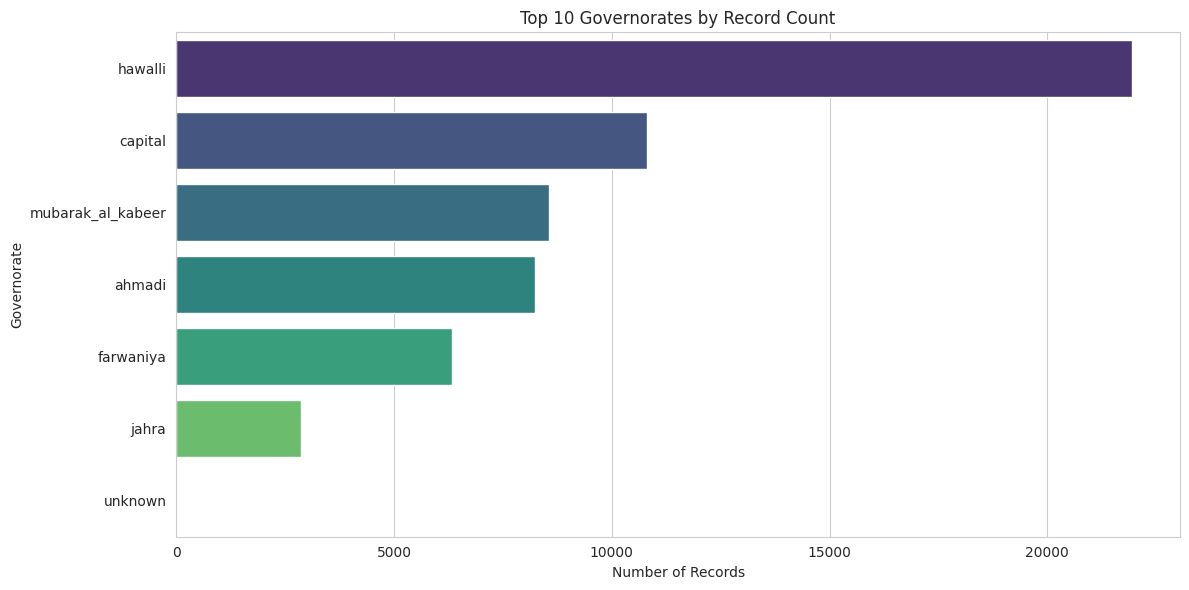

📊 Governorate counts (top 10):
governorate
hawalli              21948
capital              10813
mubarak_al_kabeer     8570
ahmadi                8248
farwaniya             6336
jahra                 2865
unknown                  6
Name: count, dtype: int64


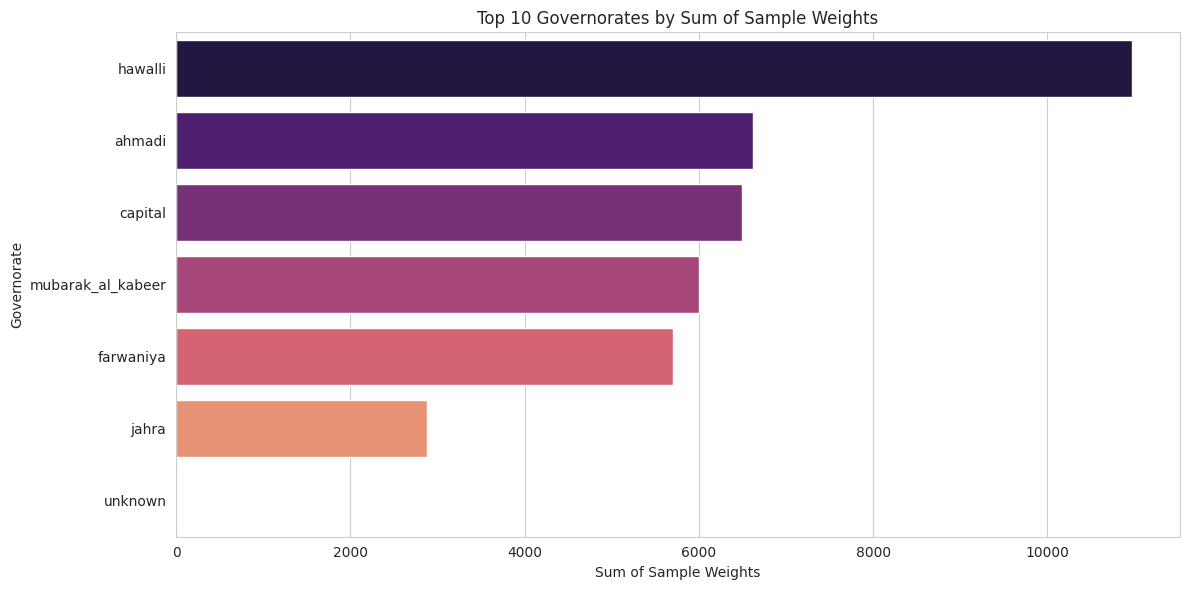

📊 Governorate sample weight sums (top 10):
governorate
hawalli              10974.435517
ahmadi                6626.752740
capital               6490.389205
mubarak_al_kabeer     5999.701719
farwaniya             5704.040817
jahra                 2875.742328
unknown                 11.000049
Name: sample_weight, dtype: float64


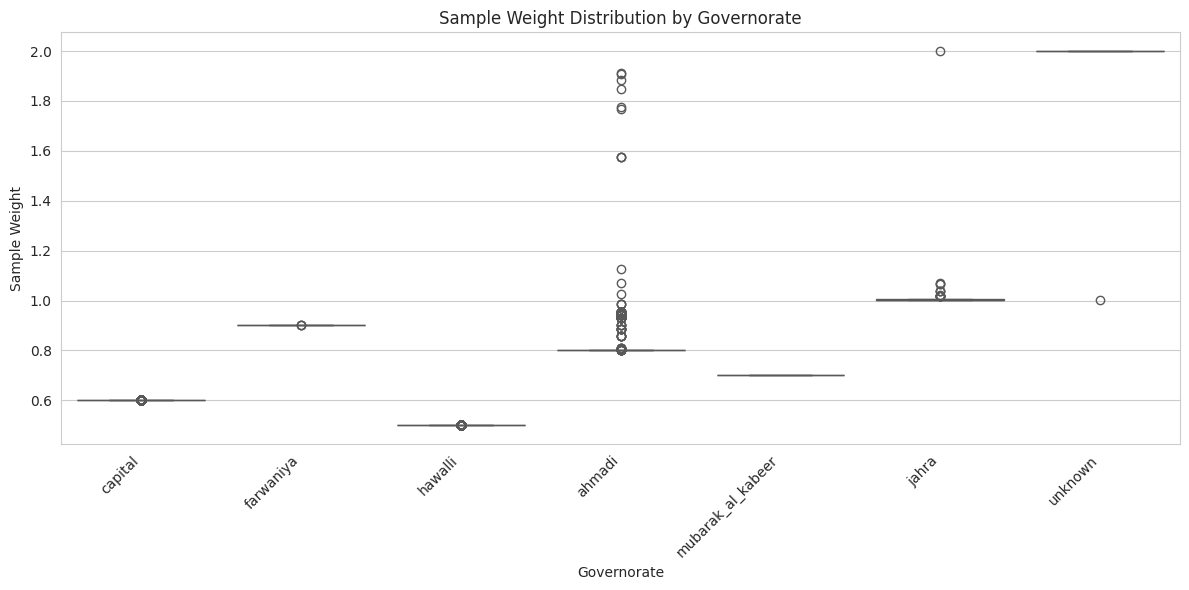


⚖️ Sample Weight Summary by Governorate:
                     count      mean       std       min       25%       50%  \
governorate                                                                    
ahmadi              8248.0  0.803438  0.035991  0.800183  0.800343  0.800486   
capital            10813.0  0.600239  0.000420  0.600004  0.600036  0.600058   
farwaniya           6336.0  0.900259  0.000177  0.900034  0.900111  0.900174   
hawalli            21948.0  0.500020  0.000021  0.500000  0.500005  0.500013   
jahra               2865.0  1.003750  0.018898  1.000926  1.001135  1.003940   
mubarak_al_kabeer   8570.0  0.700082  0.000052  0.700009  0.700035  0.700071   
unknown                6.0  1.833342  0.408228  1.000049  2.000000  2.000000   

                        75%       max  
governorate                            
ahmadi             0.800671  1.911341  
capital            0.600125  0.601776  
farwaniya          0.900409  0.902610  
hawalli            0.500027  0.500146

In [54]:
# Governorate Distribution Visualizations (Post-Weight Sampling)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure governorate column exists
if 'governorate' in df.columns:
    # 1. Bar Plot: Record Count per Governorate
    plt.figure(figsize=(12, 6))
    gov_counts = df['governorate'].value_counts().head(10)  # Top 10 for readability
    sns.barplot(x=gov_counts.values, y=gov_counts.index, palette='viridis')
    plt.title('Top 10 Governorates by Record Count')
    plt.xlabel('Number of Records')
    plt.ylabel('Governorate')
    plt.tight_layout()
    plt.show()
    print(f"📊 Governorate counts (top 10):\n{gov_counts}")

    # 2. Bar Plot: Sum of Sample Weights per Governorate
    plt.figure(figsize=(12, 6))
    gov_weights = df.groupby('governorate')['sample_weight'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=gov_weights.values, y=gov_weights.index, palette='magma')
    plt.title('Top 10 Governorates by Sum of Sample Weights')
    plt.xlabel('Sum of Sample Weights')
    plt.ylabel('Governorate')
    plt.tight_layout()
    plt.show()
    print(f"📊 Governorate sample weight sums (top 10):\n{gov_weights}")

    # 3. Boxplot: Sample Weight Distribution by Governorate
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='governorate', y='sample_weight', data=df, palette='Set2')
    plt.title('Sample Weight Distribution by Governorate')
    plt.xlabel('Governorate')
    plt.ylabel('Sample Weight')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Summary stats for sample weights by governorate
    print("\n⚖️ Sample Weight Summary by Governorate:")
    print(df.groupby('governorate')['sample_weight'].describe())
else:
    print("⚠️ No 'governorate' column found in DataFrame. Skipping governorate visualizations.")

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# ----------------------
# Training preprocessing
# ----------------------
def create_geocoding_features(df):
    print("🔧 Creating geocoding features...")

    if df.empty:
        print("❌ Empty dataframe provided")
        return df, None

    df = df.copy()

    # Hierarchical geographic features
    for col in ['country', 'area', 'city', 'governorate']:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
            # Mean coordinates for each geographic level
            df[f'{col}_lat_mean'] = df.groupby(col)['latitude'].transform('mean')
            df[f'{col}_lon_mean'] = df.groupby(col)['longitude'].transform('mean')
            # Standard deviation (measure of spread)
            df[f'{col}_lat_std'] = df.groupby(col)['latitude'].transform('std').fillna(0)
            df[f'{col}_lon_std'] = df.groupby(col)['longitude'].transform('std').fillna(0)

    # Block-level features (very important for Kuwait)
    if 'block' in df.columns and 'area' in df.columns:
        df['area_block'] = df['area'].astype(str) + '_' + df['block'].astype(str)
        df['area_block_lat_mean'] = df.groupby('area_block')['latitude'].transform('mean')
        df['area_block_lon_mean'] = df.groupby('area_block')['longitude'].transform('mean')

    # Building number features (already handled in handle_missing_data)
    # Just ensure they exist
    if 'building_num' not in df.columns:
        df['building_num'] = pd.to_numeric(
            df['buildingNumber'].astype(str).str.extract(r'(\d+)', expand=False),
            errors='coerce'
        ).fillna(-1)
        df['has_building'] = (df['building_num'] >= 0).astype(int)

    # TF-IDF features for character-level patterns
    print("📊 Creating TF-IDF features...")
    tfidf = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2, 6),  # Extended range for better pattern capture
        max_features=1024,    # More features for better coverage
        min_df=3,            # Minimum document frequency
        token_pattern=r'\b\w+\b'
    )

    tfidf_features = tfidf.fit_transform(df['input_text'].fillna(""))
    tfidf_df = pd.DataFrame(
        tfidf_features.toarray(),
        columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])],
        index=df.index
    )

    df = pd.concat([df, tfidf_df], axis=1)

    print(f"✅ Created {tfidf_features.shape[1]} TF-IDF features")
    return df, tfidf

# Apply feature engineering
if not df.empty:
    df_enhanced, tfidf_vectorizer = create_geocoding_features(df)

    print("🤖 Generating sentence embeddings...")
    embedder = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')#paraphrase-multilingual-MiniLM-L12-v2
    address_embeddings = embedder.encode(
        df_enhanced['input_text'].tolist(),
        batch_size=512,
        show_progress_bar=True
    )

    # Define feature columns (adjust based on what was actually created)
    geographic_features = []
    for col in df_enhanced.columns:
        if any(suffix in col for suffix in ['_lat_mean', '_lon_mean', '_lat_std', '_lon_std']):
            geographic_features.append(col)

    # Add numeric features
    numeric_features = ['building_num', 'has_building', 'block_num', 'has_block',
                       'has_apartment', 'has_floor']
    for feat in numeric_features:
        if feat in df_enhanced.columns:
            geographic_features.append(feat)

    # Add TF-IDF features
    tfidf_features = [col for col in df_enhanced.columns if col.startswith('tfidf_')]

    all_manual_features = geographic_features + tfidf_features

    print(f"📊 Geographic features: {len(geographic_features)}")
    print(f"📊 TF-IDF features: {len(tfidf_features)}")

    # Combine all features
    manual_features = df_enhanced[all_manual_features].fillna(0).values
    X = np.hstack([address_embeddings, manual_features])
    y = df_enhanced[["latitude", "longitude"]].values
    # Validate weights size
    weights = df_enhanced['sample_weight'].values
    if len(weights) != len(df_enhanced):
        print(f"⚠️ Weights size mismatch: expected {len(df_enhanced)}, got {len(weights)}. Recomputing weights...")
        weights = compute_density_weights(df_enhanced, bandwidth=0.1, subsample_size=10000)
        df_enhanced['sample_weight'] = weights
    print(f"✅ Recomputed weights with size: {len(weights)}")
    print(f"✅ Final feature matrix shape: {X.shape}")
    print(f"   - Sentence embeddings: {address_embeddings.shape[1]} dims")
    print(f"   - Manual features: {manual_features.shape[1]} dims")


🔧 Creating geocoding features...
📊 Creating TF-IDF features...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


✅ Created 1024 TF-IDF features
🤖 Generating sentence embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

📊 Geographic features: 20
📊 TF-IDF features: 1024
✅ Recomputed weights with size: 58786
✅ Final feature matrix shape: (58786, 1428)
   - Sentence embeddings: 384 dims
   - Manual features: 1044 dims


In [16]:
# Add this to your training pipeline to save geographic statistics
def save_geo_stats(df: pd.DataFrame, models_dir: str = "models"):
    """Save geographic statistics for use during inference"""
    geo_stats = {}
    for col in ['country', 'area', 'city', 'governorate', 'area_block']:
        if col in df.columns:
            if 'latitude' in df.columns and 'longitude' in df.columns:
                geo_stats[f'{col}_lat_mean'] = {'mean': df.groupby(col)['latitude'].mean().to_dict()}
                geo_stats[f'{col}_lon_mean'] = {'mean': df.groupby(col)['longitude'].mean().to_dict()}
                geo_stats[f'{col}_lat_std'] = {'std': df.groupby(col)['latitude'].std().fillna(0).to_dict()}
                geo_stats[f'{col}_lon_std'] = {'std': df.groupby(col)['longitude'].std().fillna(0).to_dict()}
    joblib.dump(geo_stats, os.path.join(models_dir, "geo_stats.pkl"))
    print("✅ Saved geographic statistics")



In [17]:
# Create models directory
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)
# Save geographic statistics
save_geo_stats(df_enhanced, models_dir="models")

✅ Saved geographic statistics


In [18]:
import json

In [19]:
# ========== TRAIN-TEST SPLIT ========== #
# Train-test split with weights
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, df_enhanced['sample_weight'].values, test_size=0.2, random_state=42
)

# Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print(f"✅ Training set: {X_train_scaled.shape}")
print(f"✅ Test set: {X_test_scaled.shape}")
print(f"✅ Training weights shape: {weights_train.shape}")



print("\n🎯 Data preparation completed successfully!")
print(f"📊 Final dataset statistics:")
print(f"   - Total samples: {len(df_enhanced)}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Latitude range: {y[:, 0].min():.4f} to {y[:, 0].max():.4f}")
print(f"   - Longitude range: {y[:, 1].min():.4f} to {y[:, 1].max():.4f}")

# In training pipeline, after creating X_train_scaled
feature_stats = {
    'mean': np.mean(X_train_scaled, axis=0).tolist(),
    'std': np.std(X_train_scaled, axis=0).tolist(),
    'min': np.min(X_train_scaled, axis=0).tolist(),
    'max': np.max(X_train_scaled, axis=0).tolist()
}
with open(os.path.join(models_dir, 'feature_stats.json'), 'w') as f:
    json.dump(feature_stats, f, indent=2)
print("✅ Saved feature statistics for debugging")

✅ Training set: (47028, 1428)
✅ Test set: (11758, 1428)
✅ Training weights shape: (47028,)

🎯 Data preparation completed successfully!
📊 Final dataset statistics:
   - Total samples: 58786
   - Features: 1428
   - Latitude range: 28.5755 to 29.8282
   - Longitude range: 47.6408 to 48.3730
✅ Saved feature statistics for debugging


In [20]:
import numpy as np
import os

# Verify training set size
print(f"Training set size: {len(weights_train)}")  # Should be 38333

# If size is incorrect, recompute weights
if len(weights_train) != 38333:
    print("⚠️ Training set size mismatch, recomputing weights...")
    df_train = df_enhanced.iloc[train_test_split(range(len(df_enhanced)), test_size=0.2, random_state=42)[0]]
    weights_train = compute_density_weights(df_train, bandwidth=0.1, subsample_size=10000)
    print(f"Regenerated weights_train size: {len(weights_train)}")

# Save the weights
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)
weights_path = os.path.join(models_dir, 'sample_weights.npy')
np.save(weights_path, weights_train)
print(f"✅ Saved sample weights to {weights_path} ({len(weights_train)} samples)")

Training set size: 47028
⚠️ Training set size mismatch, recomputing weights...
🔄 Computing density-based weights for governorate balancing...
📉 Subsampling 10000 points for KDE fitting...
📊 Sample weight range: min=0.5000, max=2.0000
📊 Example weights per governorate:
   hawalli: 0.5000
   capital: 0.6000
   mubarak_al_kabeer: 0.7000
   ahmadi: 0.8003
   farwaniya: 0.9000
   jahra: 1.0001
   unknown: 1.8000
Regenerated weights_train size: 47028
✅ Saved sample weights to models/sample_weights.npy (47028 samples)


/tmp/ipython-input-2118042187.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sample_weight'] = output_weights


# training

In [21]:

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate haversine distance in meters"""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 6371000 * 2 * asin(sqrt(a))

def evaluate_geocoding_model(y_true, y_pred, model_name="Model"):
    """Comprehensive evaluation for geocoding models"""

    # Basic regression metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Geographic distance metrics
    distances = [haversine_distance(a[0], a[1], b[0], b[1]) for a, b in zip(y_true, y_pred)]
    distances = np.array(distances)

    # Kuwait-specific accuracy thresholds
    thresholds = [20, 50, 100, 200, 500, 1000]
    accuracies = {f"within_{t}m": (distances <= t).mean() * 100 for t in thresholds}

    print(f"\n🎯 {model_name} Results:")
    print(f"📊 R² Score: {r2:.4f}")
    print(f"📍 RMSE: {rmse:.6f}")
    print(f"📏 Mean Distance Error: {distances.mean():.2f} m")
    print(f"📏 Median Distance Error: {np.median(distances):.2f} m")
    print(f"📏 95th Percentile Error: {np.percentile(distances, 95):.2f} m")

    for threshold, accuracy in accuracies.items():
        print(f"🎯 {threshold}: {accuracy:.2f}%")

    return {
        'r2': r2,
        'rmse': rmse,
        'mean_distance': distances.mean(),
        'median_distance': np.median(distances),
        'distances': distances,
        **accuracies
    }


In [22]:
#!pip install haversine

In [23]:
class EnhancedXGBoostGeocoder:
    def __init__(self):
        self.lat_model = None
        self.lon_model = None
        self.scaler = None

    def get_optimized_params(self):
        """Optimized XGBoost parameters for geocoding"""
        return {
            'n_estimators': 800,
            'max_depth': 8,
            'learning_rate': 0.03,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'colsample_bylevel': 0.85,
            'reg_alpha': 0.5,
            'reg_lambda': 0.3,
            'min_child_weight': 3,
            'gamma': 0.1,
            'tree_method': 'hist',
            'n_jobs': -1,
            'random_state': 42,
            'objective': 'reg:squarederror',
            'verbosity': 0,
            'early_stopping_rounds': 30,
            'enable_categorical': False
        }

    def train(self, X_train, y_train, X_val=None, y_val=None, weights_train=None):
        """Train separate XGBoost models for lat/lon with early stopping and sample weights"""
        print("🚀 Training Enhanced XGBoost models...")

        params = self.get_optimized_params()

        # Create models with early stopping parameters
        self.lat_model = xgb.XGBRegressor(**params)
        self.lon_model = xgb.XGBRegressor(**params)

        # Prepare evaluation sets if validation data is provided
        if X_val is not None and y_val is not None:
            print("   Using validation set for early stopping...")

            # Train latitude model with validation and weights
            self.lat_model.fit(
                X_train, y_train[:, 0],
                sample_weight=weights_train,
                eval_set=[(X_val, y_val[:, 0])],
                verbose=False
            )

            # Train longitude model with validation and weights
            self.lon_model.fit(
                X_train, y_train[:, 1],
                sample_weight=weights_train,
                eval_set=[(X_val, y_val[:, 1])],
                verbose=False
            )
        else:
            print("   Training without validation set...")

            # Train without validation (no early stopping)
            params_no_early_stop = {k: v for k, v in params.items()
                                  if k != 'early_stopping_rounds'}

            self.lat_model = xgb.XGBRegressor(**params_no_early_stop)
            self.lon_model = xgb.XGBRegressor(**params_no_early_stop)

            # Simple training with weights
            self.lat_model.fit(X_train, y_train[:, 0], sample_weight=weights_train)
            self.lon_model.fit(X_train, y_train[:, 1], sample_weight=weights_train)

        print("✅ XGBoost models trained successfully!")
        return self

    def predict(self, X):
        """Make predictions using both latitude and longitude models"""
        if self.lat_model is None or self.lon_model is None:
            raise ValueError("Models not trained yet. Call train() first.")

        lat_pred = self.lat_model.predict(X)
        lon_pred = self.lon_model.predict(X)
        return np.column_stack((lat_pred, lon_pred))

    def get_feature_importance(self):
        """Get feature importance from both models"""
        if self.lat_model is None or self.lon_model is None:
            raise ValueError("Models not trained yet. Call train() first.")

        return {
            'latitude_importance': self.lat_model.feature_importances_,
            'longitude_importance': self.lon_model.feature_importances_
        }

In [24]:
# ==================== MODEL 2: LIGHTGBM ALTERNATIVE ==================== #

class LightGBMGeocoder:
    def __init__(self):
        self.lat_model = None
        self.lon_model = None

    def get_optimized_params(self):
        return {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 127,
            'learning_rate': 0.05,
            'feature_fraction': 0.85,
            'bagging_fraction': 0.85,
            'bagging_freq': 5,
            'reg_alpha': 0.1,
            'reg_lambda': 0.15,
            'min_child_samples': 20,
            'n_estimators': 500,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1
        }

    def train(self, X_train, y_train, X_val=None, y_val=None):
        print("🌟 Training LightGBM models...")

        params = self.get_optimized_params()

        # Setup validation
        eval_sets = [X_train, y_train[:, 0]]
        if X_val is not None:
            eval_sets = [(X_train, y_train[:, 0]), (X_val, y_val[:, 0])]

        # Train models
        self.lat_model = lgb.LGBMRegressor(**params)
        self.lon_model = lgb.LGBMRegressor(**params)

        self.lat_model.fit(X_train, y_train[:, 0])
        self.lon_model.fit(X_train, y_train[:, 1])

        return self

    def predict(self, X):
        lat_pred = self.lat_model.predict(X)
        lon_pred = self.lon_model.predict(X)
        return np.column_stack((lat_pred, lon_pred))

In [25]:
class HybridXGBFAISSGeocoder:
    def __init__(self, k_neighbors=3, models_dir="models"):
        self.xgb_geocoder = EnhancedXGBoostGeocoder()
        self.faiss_lat_index = None
        self.faiss_lon_index = None
        self.residuals = None
        self.k = k_neighbors
        self.X_train_ref = None
        self.weights_train = None
        self.distance_weighting = 'inverse_squared'
        self.residual_cap = 0.01
        self.models_dir = models_dir  # New: Directory for saving artifacts

    def train(self, X_train, y_train, X_val=None, y_val=None, weights_train=None):
        print("🔥 Training Hybrid XGBoost + FAISS model...")

        # 1. Train XGBoost base models with weights
        self.xgb_geocoder.train(X_train, y_train, X_val, y_val, weights_train=weights_train)

        # 2. Calculate residuals (weight-adjusted)
        xgb_pred = self.xgb_geocoder.predict(X_train)
        self.residuals = y_train - xgb_pred
        self.weights_train = weights_train

        # 3. Build FAISS indexes for residual correction
        d = X_train.shape[1]
        X_train_f32 = X_train.astype(np.float32)

        self.faiss_lat_index = faiss.IndexFlatL2(d)
        self.faiss_lon_index = faiss.IndexFlatL2(d)

        self.faiss_lat_index.add(X_train_f32)
        self.faiss_lon_index.add(X_train_f32)

        self.X_train_ref = X_train_f32

        # Save artifacts separately
        os.makedirs(self.models_dir, exist_ok=True)
        faiss.write_index(self.faiss_lat_index, os.path.join(self.models_dir, 'faiss_lat_index.index'))
        faiss.write_index(self.faiss_lon_index, os.path.join(self.models_dir, 'faiss_lon_index.index'))
        np.save(os.path.join(self.models_dir, 'X_train_ref.npy'), X_train_f32)
        np.save(os.path.join(self.models_dir, 'residuals.npy'), self.residuals)
        if self.weights_train is not None:
            np.save(os.path.join(self.models_dir, 'sample_weights.npy'), self.weights_train)

        # Clear large arrays from object to keep it lightweight
        self.faiss_lat_index = None
        self.faiss_lon_index = None
        self.X_train_ref = None
        self.residuals = None
        self.weights_train = None

        print(f"✅ FAISS indexes built with {len(X_train)} reference points")
        return self

    def load_artifacts(self):
        """Load FAISS artifacts for prediction (new method)"""
        self.faiss_lat_index = faiss.read_index(os.path.join(self.models_dir, 'faiss_lat_index.index'))
        self.faiss_lon_index = faiss.read_index(os.path.join(self.models_dir, 'faiss_lon_index.index'))
        self.X_train_ref = np.load(os.path.join(self.models_dir, 'X_train_ref.npy'))
        self.residuals = np.load(os.path.join(self.models_dir, 'residuals.npy'))
        weights_path = os.path.join(self.models_dir, 'sample_weights.npy')
        if os.path.exists(weights_path):
            self.weights_train = np.load(weights_path)
        else:
            self.weights_train = None

    def predict(self, X):
        """Make predictions using both latitude and longitude models"""
        if self.xgb_geocoder.lat_model is None or self.xgb_geocoder.lon_model is None:
            raise ValueError("Models not trained yet. Call train() first.")

        # Load artifacts if not present
        if self.faiss_lat_index is None:
            self.load_artifacts()

        # 1. Get XGBoost base predictions
        xgb_pred = self.xgb_geocoder.predict(X)

        # 2. FAISS residual correction
        X_f32 = X.astype(np.float32)

        # Find k nearest neighbors
        dist_lat, idx_lat = self.faiss_lat_index.search(X_f32, self.k)
        dist_lon, idx_lon = self.faiss_lon_index.search(X_f32, self.k)

        # Distance-weighted residual correction
        eps = 1e-8
        weights_lat = 1 / (dist_lat + eps)
        weights_lon = 1 / (dist_lon + eps)
        weights_lat /= weights_lat.sum(axis=1, keepdims=True)
        weights_lon /= weights_lon.sum(axis=1, keepdims=True)

        # Apply sample weights to residuals if available
        if self.weights_train is not None:
            weights_lat = weights_lat * self.weights_train[idx_lat]
            weights_lon = weights_lon * self.weights_train[idx_lon]
            weights_lat /= weights_lat.sum(axis=1, keepdims=True)
            weights_lon /= weights_lon.sum(axis=1, keepdims=True)

        # Apply corrections
        correction_lat = (weights_lat * self.residuals[idx_lat, 0]).sum(axis=1)
        correction_lon = (weights_lon * self.residuals[idx_lon, 1]).sum(axis=1)

        # Final predictions
        final_pred = xgb_pred + np.column_stack((correction_lat, correction_lon))

        # Clear artifacts to free memory
        self.faiss_lat_index = None
        self.faiss_lon_index = None
        self.X_train_ref = None
        self.residuals = None
        self.weights_train = None

        return final_pred

In [26]:
# ==================== MODEL 4: NEURAL NETWORK ==================== #

class GeoCodingNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64]):
        super(GeoCodingNN, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 2))  # Output: lat, lon

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class NeuralNetworkGeocoder:
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64]):
        self.model = GeoCodingNN(input_dim, hidden_dims)
        self.input_scaler = StandardScaler()
        self.output_scaler = StandardScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=200, batch_size=512):
        print(f"🧠 Training Neural Network on {self.device}...")

        # ✅ Scale both inputs AND outputs
        X_train_scaled = self.input_scaler.fit_transform(X_train)
        y_train_scaled = self.output_scaler.fit_transform(y_train)

        # Convert to tensors
        X_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
        y_tensor = torch.FloatTensor(y_train_scaled).to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        criterion = nn.MSELoss()

        # Training loop
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            scheduler.step(avg_loss)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")

        return self

    def predict(self, X):
        self.model.eval()
        X_scaled = self.input_scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)

        with torch.no_grad():
            scaled_pred = self.model(X_tensor).cpu().numpy()
            # ✅ Inverse transform to get predictions back in original lat/lon scale
            return self.output_scaler.inverse_transform(scaled_pred)


In [27]:
class EnsembleGeocoder:
    def __init__(self):
        self.models = {}
        self.weights = {}

    def add_model(self, name, model, weight=1.0):
        """Add a model with its associated weight"""
        self.models[name] = model
        self.weights[name] = weight

    def train_all(self, X_train, y_train, X_val=None, y_val=None):
        """Train all added models"""
        print("🎯 Training Ensemble of Models...")
        for name, model in self.models.items():
            print(f"\n--- Training {name} ---")
            model.train(X_train, y_train, X_val, y_val)
        return self

    def predict(self, X):
        """Weighted prediction from all valid models"""
        predictions = []
        total_weight = 0

        for name, model in self.models.items():
            try:
                pred = model.predict(X)
                if np.any(np.isnan(pred)) or pred.shape != (len(X), 2):
                    print(f"⚠️ Skipping model '{name}' due to invalid prediction shape or NaNs.")
                    continue
                weight = self.weights[name]
                predictions.append(pred * weight)
                total_weight += weight
            except Exception as e:
                print(f"❌ Model '{name}' failed during prediction: {e}")

        if total_weight == 0:
            raise ValueError("No valid models available for ensemble prediction.")

        ensemble_pred = sum(predictions) / total_weight
        return ensemble_pred


In [28]:
def train_all_models(X_train_scaled, y_train, X_test_scaled, y_test, weights_train=None):
    """Train and evaluate all models"""
    results = {}
    import os
    import numpy as np
    import joblib
    from sklearn.model_selection import train_test_split
    import faiss

    # Split training data for validation
    X_tr, X_val, y_tr, y_val, weights_tr, weights_val = train_test_split(
        X_train_scaled, y_train, weights_train, test_size=0.1, random_state=42
    )

    # Validate weights size
    if weights_tr is not None and len(weights_tr) != len(X_tr):
        raise ValueError(f"Weights size ({len(weights_tr)}) does not match training data size ({len(X_tr)})")

    # 1. Enhanced XGBoost
    print("\n" + "="*50)
    print("TRAINING ENHANCED XGBOOST")
    print("="*50)

    xgb_model = EnhancedXGBoostGeocoder()
    xgb_model.train(X_tr, y_tr, X_val, y_val, weights_tr)
    xgb_pred = xgb_model.predict(X_test_scaled)
    results['XGBoost'] = evaluate_geocoding_model(y_test, xgb_pred, "Enhanced XGBoost")

    # 2. Hybrid XGB + FAISS
    print("\n" + "="*50)
    print("TRAINING HYBRID XGB + FAISS")
    print("="*50)

    hybrid_model = HybridXGBFAISSGeocoder(k_neighbors=3)  # Default models_dir="models"
    hybrid_model.train(X_tr, y_tr, X_val, y_val, weights_tr)
    hybrid_pred = hybrid_model.predict(X_test_scaled)
    results['Hybrid'] = evaluate_geocoding_model(y_test, hybrid_pred, "Hybrid XGB + FAISS")

    # Save artifacts
    os.makedirs(models_dir, exist_ok=True)
    joblib.dump(hybrid_model, os.path.join(models_dir, 'hybrid_xgbfaiss_geocoder.pkl'))

    # Summary comparison
    print("\n" + "="*60)
    print("FINAL COMPARISON")
    print("="*60)

    comparison_df = pd.DataFrame({
        model: {
            'Mean Distance (m)': res['mean_distance'],
            'Within 100m (%)': res['within_100m'],
            'Within 200m (%)': res['within_200m'],
            'R² Score': res['r2']
        }
        for model, res in results.items()
    }).T

    print(comparison_df.round(2))

    return results, {
        'xgb': xgb_model,
        'hybrid': hybrid_model
    }

In [29]:
import faiss
import faiss.contrib.torch_utils  # Optional if integrating with PyTorch


In [30]:
import os
import json
import joblib
import torch
import numpy as np
import faiss

if __name__ == "__main__":
    print("🚀 Starting Kuwait Geocoding Model Training Pipeline")
    print("=" * 60)

    # Check if we have the required data from previous steps
    try:
        print(f"✅ Training data shape: {X_train_scaled.shape}")
        print(f"✅ Test data shape: {X_test_scaled.shape}")
        print(f"✅ Training targets shape: {y_train.shape}")
        print(f"✅ Test targets shape: {y_test.shape}")
    except NameError:
        print("❌ Error: Required data not found!")
        print("Please run the data preparation code first to create:")
        print("- X_train_scaled, X_test_scaled")
        print("- y_train, y_test")
        print("- scaler_X, embedder, tfidf_vectorizer")
        exit(1)

    # Define models directory
    models_dir = "models"
    os.makedirs(models_dir, exist_ok=True)

    try:
        # Validate weights
        if len(weights_train) != len(X_train_scaled):
            print("⚠️ Weights size mismatch, recomputing...")
            weights_train = compute_density_weights(df_enhanced.iloc[:len(X_train_scaled)], bandwidth=0.1, subsample_size=10000)

        # Train all models
        results, trained_models = train_all_models(X_train_scaled, y_train, X_test_scaled, y_test, weights_train=weights_train)
        print("\n🎉 Training completed successfully!")

        # ==================== SAVE MODELS ==================== #
        print("\n📦 Saving trained models and artifacts...")

        # Define feature dimensions
        feature_dimensions = X_train_scaled.shape[1]
        joblib.dump(feature_dimensions, os.path.join(models_dir, 'feature_dimensions.pkl'))
        print(f"✅ Saved feature dimensions: {feature_dimensions}")

        # Save individual models
        print("💾 Saving XGBoost model...")
        joblib.dump(trained_models['xgb'], os.path.join(models_dir, 'xgboost_geocoder.pkl'))

        print("💾 Saving Hybrid XGB + FAISS model...")
        joblib.dump(trained_models['hybrid'], os.path.join(models_dir, 'hybrid_xgbfaiss_geocoder.pkl'))
        print("✅ Saved FAISS indexes and residuals")

        # Save preprocessing artifacts
        print("💾 Saving preprocessing artifacts...")
        joblib.dump(scaler_X, os.path.join(models_dir, 'feature_scaler.pkl'))
        joblib.dump(tfidf_vectorizer, os.path.join(models_dir, 'tfidf_vectorizer.pkl'))
        joblib.dump(all_manual_features, os.path.join(models_dir, 'manual_feature_columns.pkl'))

        # Save sentence embedder
        print("💾 Saving sentence embedder...")
        embedder.save(os.path.join(models_dir, 'sentence_embedder'))

        # Save address normalization dictionaries
        print("💾 Saving address normalization dictionaries...")

        # Convert sets to lists in KUWAIT_GOVERNORATES
        kuwait_governorates_serializable = {
            governorate: sorted(list(areas))  # Convert set to sorted list for consistency
            for governorate, areas in KUWAIT_GOVERNORATES.items()
        }

        address_dicts = {
            'kuwait_governorates': kuwait_governorates_serializable,
            'abbreviation_map': ABBREVIATION_MAP,
            'common_typos': COMMON_TYPOS
        }

        # Debug: Print KUWAIT_GOVERNORATES to verify
        print("KUWAIT_GOVERNORATES:", json.dumps(address_dicts['kuwait_governorates'], indent=2, ensure_ascii=False))
        with open(os.path.join(models_dir, 'address_normalization_dicts.json'), 'w', encoding='utf-8') as f:
            json.dump(address_dicts, f, indent=2, ensure_ascii=False)
        print("✅ Saved address_normalization_dicts.json")

        # Save training results
        print("📝 Saving training results and metadata...")
        results_serializable = {
            model_name: {
                key: float(value) if isinstance(value, (np.float64, np.float32)) else
                     value.tolist() if isinstance(value, np.ndarray) else value
                for key, value in model_results.items()
            }
            for model_name, model_results in results.items()
        }
        with open(os.path.join(models_dir, 'training_results.json'), 'w') as f:
            json.dump(results_serializable, f, indent=2)

        # Save metadata
        embedding_dimensions = address_embeddings.shape[1] if 'address_embeddings' in globals() else None
        manual_feature_dims = manual_features.shape[1] if 'manual_features' in globals() else None
        governorate_dist = df_enhanced['governorate'].value_counts().to_dict() if 'df_enhanced' in globals() else {}
        metadata = {
            'training_samples': len(X_train_scaled),
            'test_samples': len(X_test_scaled),
            'feature_dimensions': feature_dimensions,
            'embedding_dimensions': embedding_dimensions,
            'manual_features': manual_feature_dims,
            'governorate_distribution': governorate_dist,
            'geohash_precision': 6,
            'kuwait_bounds': {
                'lat_min': 28.524574,
                'lat_max': 30.103532,
                'lon_min': 46.552695,
                'lon_max': 48.416094
            },
            'ensemble_weights': {
                'xgb': 0.43,
                'hybrid': 0.57
            },
            'model_version': '1.0'
        }
        with open(os.path.join(models_dir, 'training_metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)

        # Save environment requirements
        print("💾 Saving environment requirements...")
        os.system(f"pip freeze > {os.path.join(models_dir, 'requirements.txt')}")
        print("✅ Saved all model artifacts")
        print(f"\n✅ All models and artifacts saved in '{models_dir}/' directory")

    except Exception as e:
        print(f"\n❌ Training or saving failed: {e}")
        exit(1)

    print("\n🏁 Pipeline completed successfully.")

🚀 Starting Kuwait Geocoding Model Training Pipeline
✅ Training data shape: (47028, 1428)
✅ Test data shape: (11758, 1428)
✅ Training targets shape: (47028, 2)
✅ Test targets shape: (11758, 2)

TRAINING ENHANCED XGBOOST
🚀 Training Enhanced XGBoost models...
   Using validation set for early stopping...
✅ XGBoost models trained successfully!

🎯 Enhanced XGBoost Results:
📊 R² Score: 0.9951
📍 RMSE: 0.005580
📏 Mean Distance Error: 462.97 m
📏 Median Distance Error: 368.20 m
📏 95th Percentile Error: 1128.89 m
🎯 within_20m: 0.19%
🎯 within_50m: 1.26%
🎯 within_100m: 5.13%
🎯 within_200m: 18.94%
🎯 within_500m: 70.90%
🎯 within_1000m: 93.49%

TRAINING HYBRID XGB + FAISS
🔥 Training Hybrid XGBoost + FAISS model...
🚀 Training Enhanced XGBoost models...
   Using validation set for early stopping...
✅ XGBoost models trained successfully!
✅ FAISS indexes built with 42325 reference points

🎯 Hybrid XGB + FAISS Results:
📊 R² Score: 0.9989
📍 RMSE: 0.002645
📏 Mean Distance Error: 116.15 m
📏 Median Distance Er

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic

🔍 Inspecting results structure...
Results keys: ['XGBoost', 'Hybrid']
Sample result: {'XGBoost': ['r2', 'rmse', 'mean_distance', 'median_distance', 'distances']}

🔍 Inspecting trained_models structure...
trained_models keys: ['xgb', 'hybrid']

🔍 Computing predictions and distance errors...
✅ XGBoost predictions computed. Mean distance error: 462.56m
✅ Hybrid predictions computed. Mean distance error: 116.07m


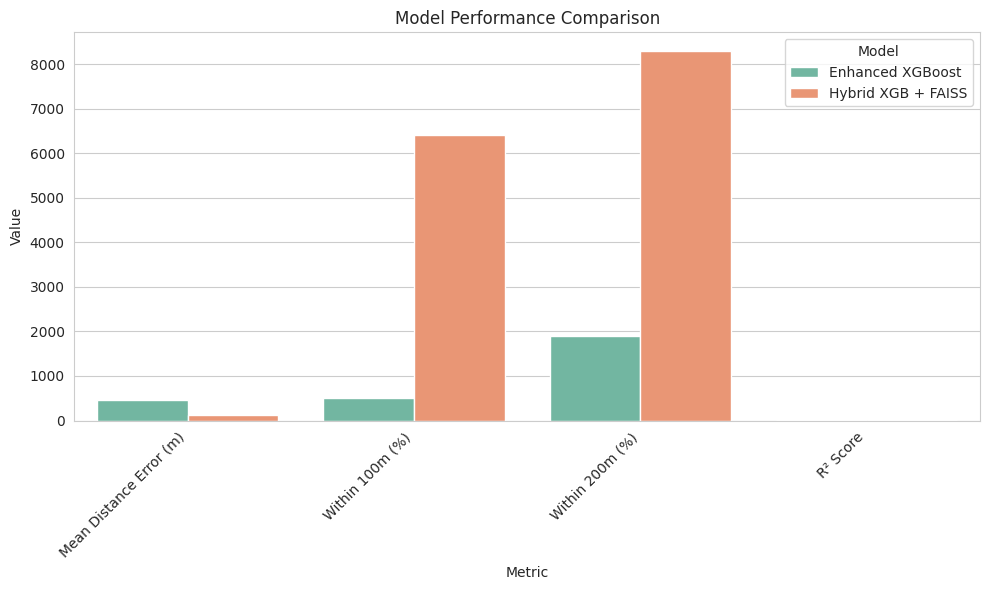

In [66]:
# Model Evaluation Plots and Metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic

# Debug: Inspect results and trained_models structure
print("🔍 Inspecting results structure...")
print("Results keys:", list(results.keys()))
if isinstance(results, dict) and results:
    print("Sample result:", {k: list(results[k].keys())[:5] for k in list(results.keys())[:1]})  # Show first 5 metric keys

print("\n🔍 Inspecting trained_models structure...")
print("trained_models keys:", list(trained_models.keys()))

# Function to compute distance errors
def compute_distance_errors(y_true, y_pred):
    distances = []
    for true, pred in zip(y_true, y_pred):
        true_coord = (true[0], true[1])  # latitude, longitude
        pred_coord = (pred[0], pred[1])
        distance = geodesic(true_coord, pred_coord).meters
        distances.append(distance)
    return np.array(distances)

# Compute predictions and distance errors
print("\n🔍 Computing predictions and distance errors...")
models = ['XGBoost', 'Hybrid']
predictions = {}
distance_errors = {}

# Mapping for trained_models keys (respect pipeline naming: 'xgb' for XGBoost, 'hybrid' for Hybrid)
trained_models_map = {
    'XGBoost': 'xgb',
    'Hybrid': 'hybrid'
}

for model_name in models:
    trained_key = trained_models_map[model_name]
    if trained_key not in trained_models:
        raise KeyError(f"Trained model key '{trained_key}' not found in trained_models. Available: {list(trained_models.keys())}")
    model = trained_models[trained_key]
    y_pred = model.predict(X_test_scaled)
    predictions[model_name] = y_pred
    distance_errors[model_name] = compute_distance_errors(y_test, y_pred)
    print(f"✅ {model_name} predictions computed. Mean distance error: {distance_errors[model_name].mean():.2f}m")

# Prepare results DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
for col in ['mean_distance', 'within_100m', 'within_200m', 'r2']:
    if col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

# Rename models for display (respect pipeline naming)
results_df['Model'] = results_df['Model'].replace({
    'XGBoost': 'Enhanced XGBoost',
    'Hybrid': 'Hybrid XGB + FAISS'
})

# 1. Bar Plot: Comparison of Model Metrics
plt.figure(figsize=(10, 6))
metrics_df_melted = results_df.melt(id_vars='Model', value_vars=['mean_distance', 'within_100m', 'within_200m', 'r2'],
                                    var_name='Metric', value_name='Value')
metrics_df_melted['Value'] = metrics_df_melted.apply(
    lambda x: x['Value'] * 100 if 'within_' in x['Metric'] else x['Value'], axis=1)
metrics_df_melted['Metric'] = metrics_df_melted['Metric'].replace({
    'mean_distance': 'Mean Distance Error (m)',
    'within_100m': 'Within 100m (%)',
    'within_200m': 'Within 200m (%)',
    'r2': 'R² Score'
})
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_df_melted, palette='Set2')
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



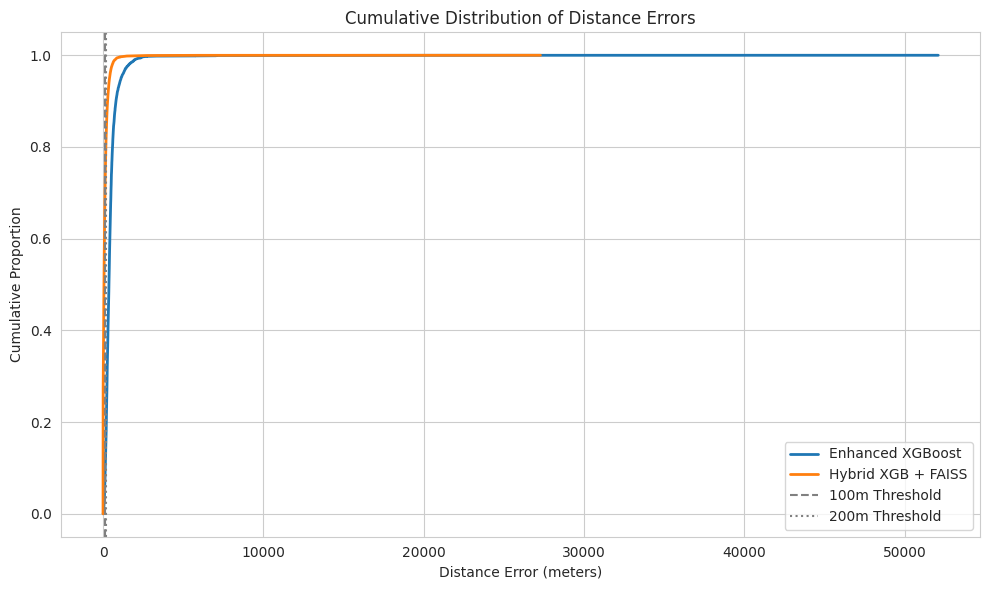

In [67]:
# 2. Cumulative Distribution Plot: Distance Errors
plt.figure(figsize=(10, 6))
for model_name in models:
    display_name = 'Enhanced XGBoost' if model_name == 'XGBoost' else 'Hybrid XGB + FAISS'
    errors = np.sort(distance_errors[model_name])
    cdf = np.arange(1, len(errors) + 1) / len(errors)
    plt.plot(errors, cdf, label=display_name, linewidth=2)
plt.axvline(x=100, color='gray', linestyle='--', label='100m Threshold')
plt.axvline(x=200, color='gray', linestyle=':', label='200m Threshold')
plt.title('Cumulative Distribution of Distance Errors')
plt.xlabel('Distance Error (meters)')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



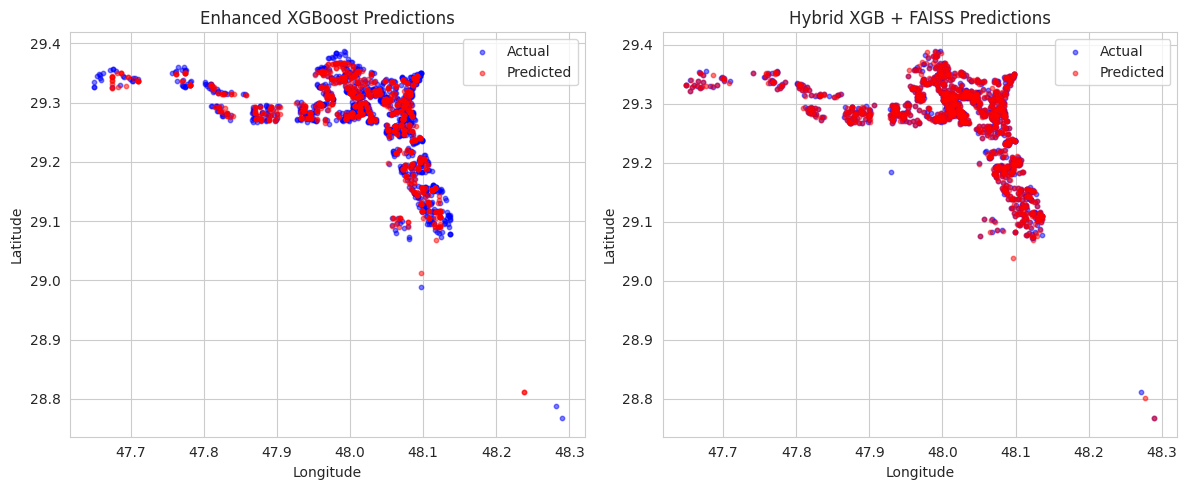

In [68]:
# 3. Scatter Plot: Predicted vs. Actual Coordinates
plt.figure(figsize=(12, 5))
for i, model_name in enumerate(models):
    plt.subplot(1, 2, i + 1)
    display_name = 'Enhanced XGBoost' if model_name == 'XGBoost' else 'Hybrid XGB + FAISS'
    sample_idx = np.random.choice(len(y_test), min(1000, len(y_test)), replace=False)
    y_true_sample = y_test[sample_idx]
    y_pred_sample = predictions[model_name][sample_idx]
    plt.scatter(y_true_sample[:, 1], y_true_sample[:, 0], c='blue', alpha=0.5, s=10, label='Actual')
    plt.scatter(y_pred_sample[:, 1], y_pred_sample[:, 0], c='red', alpha=0.5, s=10, label='Predicted')
    plt.title(f'{display_name} Predictions')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
plt.tight_layout()
plt.show()



In [69]:
# 4. Governorate-Specific Performance
if 'df_enhanced' in globals() and 'governorate' in df_enhanced.columns:
    print("🔍 Computing governorate-specific performance...")
    test_indices = df_enhanced.index[-len(y_test):]  # Assume test set is last rows
    df_test = df_enhanced.loc[test_indices].copy()
    df_test['xgb_distance_error'] = distance_errors['XGBoost']
    df_test['hybrid_distance_error'] = distance_errors['Hybrid']

    # Boxplot: Distance Errors by Governorate
    plt.figure(figsize=(12, 6))
    df_test_melted = df_test.melt(id_vars='governorate', value_vars=['xgb_distance_error', 'hybrid_distance_error'],
                                  var_name='Model', value_name='Distance Error (m)')
    df_test_melted['Model'] = df_test_melted['Model'].replace({
        'xgb_distance_error': 'Enhanced XGBoost',
        'hybrid_distance_error': 'Hybrid XGB + FAISS'
    })

    # Summary table
    gov_summary = df_test.groupby('governorate').agg({
        'xgb_distance_error': ['mean', 'median', 'count'],
        'hybrid_distance_error': ['mean', 'median']
    }).round(2)
    gov_summary.columns = ['Enhanced XGBoost Mean', 'Enhanced XGBoost Median', 'Count',
                          'Hybrid XGB + FAISS Mean', 'Hybrid XGB + FAISS Median']
    print("\n📊 Governorate-Specific Distance Errors (meters):")
    print(gov_summary)



# Save evaluation results
eval_results = {
    'XGBoost': {'distance_errors': distance_errors['XGBoost'].tolist()},
    'Hybrid': {'distance_errors': distance_errors['Hybrid'].tolist()}
}
with open(os.path.join(models_dir, 'evaluation_results.json'), 'w') as f:
    json.dump(eval_results, f, indent=2)
print(f"✅ Saved evaluation results to '{os.path.join(models_dir, 'evaluation_results.json')}'")

🔍 Computing governorate-specific performance...

📊 Governorate-Specific Distance Errors (meters):
                   Enhanced XGBoost Mean  Enhanced XGBoost Median  Count  \
governorate                                                                
Unknown                           206.58                   206.58      2   
ahmadi                            473.88                   366.21   1691   
capital                           456.49                   371.51   2252   
farwaniya                         463.75                   351.14   1162   
hawalli                           448.01                   368.74   4270   
jahra                             584.67                   363.27    523   
mubarak_al_kabeer                 458.22                   369.72   1858   

                   Hybrid XGB + FAISS Mean  Hybrid XGB + FAISS Median  
governorate                                                            
Unknown                               0.00                       0.00  
a

<Figure size 1200x600 with 0 Axes>

#testing

In [31]:
!pip install fuzzywuzzy python-Levenshtein

In [32]:
!pip install fuzzy


  Preparing metadata (setup.py) ... done
  Created wheel for fuzzy: filename=Fuzzy-1.2.2-cp312-cp312-linux_x86_64.whl size=231376 sha256=786a232a24543019892d282098c04aaafbfd46db702d48ad3eb3998421e6ffca
  Stored in directory: /root/.cache/pip/wheels/ae/17/05/e688b455079b61cb255bc2e08458d6e66894a14be5cd5a5954
Successfully built fuzzy


In [33]:
!pip install jellyfish

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.9/355.9 kB 8.2 MB/s eta 0:00:00


In [34]:
!pip install metaphone

  Preparing metadata (setup.py) ... done
  Created wheel for metaphone: filename=Metaphone-0.6-py3-none-any.whl size=13901 sha256=d5ca45e969f415867777e765b00b3916ce94325a77abbd435ef43116618bd3a1
  Stored in directory: /root/.cache/pip/wheels/d0/fc/72/0c9e56e8c85dc1b2998f4c8f5e9075b8eb71b046b519aa1759
Successfully built metaphone


In [35]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import faiss
import re
from typing import Dict, List, Tuple, Optional
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from fuzzywuzzy import process
import fuzzy
import warnings
from math import radians, cos, sin, asin, sqrt
from functools import lru_cache
warnings.filterwarnings('ignore')

# Global SentenceTransformer to avoid reloading
SENTENCE_EMBEDDER = SentenceTransformer('paraphrase-MiniLM-L6-v2')

class FixedHybridGeocoder:
    def __init__(self, models_dir: str = "models"):
        self.models_dir = models_dir
        self.artifacts = {}
        self.is_loaded = False
        self.kuwait_governorates = {}
        self.abbreviation_map = {}
        self.common_typos = {}
        self.all_kuwait_areas = []
        self.typo_patterns = []
        self.kuwait_bounds = {
            'lat_min': 28.524574,
            'lat_max': 30.103532,
            'lon_min': 46.552695,
            'lon_max': 48.416094
        }
        self.kuwait_center = {
            'latitude': 29.3759,
            'longitude': 47.9774
        }
        self.area_similarity_cache = {}

    def load_artifacts(self):
        try:
            self.artifacts['feature_scaler'] = joblib.load(os.path.join(self.models_dir, 'feature_scaler.pkl'))
            self.artifacts['tfidf_vectorizer'] = joblib.load(os.path.join(self.models_dir, 'tfidf_vectorizer.pkl'))
            self.artifacts['manual_feature_columns'] = joblib.load(os.path.join(self.models_dir, 'manual_feature_columns.pkl'))
            self.artifacts['sentence_embedder'] = SENTENCE_EMBEDDER
            self.artifacts['geo_stats'] = joblib.load(os.path.join(self.models_dir, 'geo_stats.pkl'))
            with open(os.path.join(self.models_dir, 'address_normalization_dicts.json'), 'r', encoding='utf-8') as f:
                address_dicts = json.load(f)
            self.kuwait_governorates = address_dicts['kuwait_governorates']
            self.abbreviation_map = address_dicts['abbreviation_map']
            self.common_typos = address_dicts['common_typos']
            if 'sharq' in self.abbreviation_map:
                del self.abbreviation_map['sharq']
            if 'sharq' in self.common_typos:
                self.common_typos['sharq'] = 'sharq'
            self.common_typos = {k: v for k, v in self.common_typos.items() if len(k) > 1}
            self.all_kuwait_areas = [area for gov_areas in self.kuwait_governorates.values() for area in gov_areas]
            self.all_kuwait_areas.extend([correct for typo, correct in self.common_typos.items() if correct not in self.all_kuwait_areas])
            self.all_kuwait_areas = list(set(self.normalize_text(area) for area in self.all_kuwait_areas))
            self.typo_patterns = [(re.compile(rf"\\b{re.escape(typo)}\\b", re.IGNORECASE), correct) for typo, correct in sorted(self.common_typos.items(), key=lambda x: len(x[0]), reverse=True)]
            with open(os.path.join(self.models_dir, 'training_metadata.json'), 'r') as f:
                self.artifacts['metadata'] = json.load(f)
            self.artifacts['hybrid_model'] = joblib.load(os.path.join(self.models_dir, 'hybrid_xgbfaiss_geocoder.pkl'))
            self._validate_loaded_components()
            self.is_loaded = True
        except Exception as e:
            raise RuntimeError(f"Failed to load artifacts: {e}")

    def _validate_loaded_components(self):
        expected_dims = self.artifacts['metadata']['feature_dimensions']
        actual_dims = self.artifacts['hybrid_model'].xgb_geocoder.lat_model.n_features_in_
        if expected_dims != actual_dims:
            raise ValueError(f"Feature dimension mismatch: expected {expected_dims}, got {actual_dims}")

    def normalize_text(self, text: str) -> str:
        if not text or pd.isna(text):
            return ""
        text = str(text).strip().translate(str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")).translate(str.maketrans("إأآاىئءؤ", "اااايءءء"))
        for pattern, correct in self.typo_patterns:
            text = pattern.sub(correct, text)
        text = re.sub(r"[^\w\s\d\u0600-\u06FF]", " ", text.lower())
        words = [self.abbreviation_map.get(word, word) for word in text.split()]
        return " ".join(words)

    def validate_kuwaiti_block(self, block: str) -> bool:
        if not block or pd.isna(block):
            return False
        return bool(re.fullmatch(r"^\d{1,3}[a-zA-Z]?$", str(block).strip()))

    def validate_kuwaiti_street(self, street: str) -> bool:
        if not street or pd.isna(street):
            return False
        street = self.normalize_text(street)
        return bool(re.fullmatch(
            r"^(?:street|avenue|road|lane|crescent|شارع|جادة|طريق|حارة|هلال)?\s*[\d\w\s\-]+$",
            street, re.IGNORECASE
        )) and len(street) <= 100

    def categorize_street(self, street: str) -> str:
        street = self.normalize_text(street)
        if street == "unknown" or not street:
            return "unknown"
        if re.match(r"^(?:street|avenue|road|lane|crescent|شارع|جادة|طريق|حارة|هلال)?\s*\d+$", street, re.IGNORECASE):
            return "numbered"
        if re.match(r"^(?:street|avenue|road|lane|crescent|شارع|جادة|طريق|حارة|هلال)?\s*[\w\s\-]+$", street, re.IGNORECASE):
            return "named"
        return "unknown"

    def parse_address_robust(self, address: str) -> Dict:
        if not address or not isinstance(address, str):
            return {
                'country': 'kuwait', 'area': 'unknown', 'block': 'unknown', 'street': 'unknown',
                'buildingNumber': '', 'apartment': '', 'floor': ''
            }
        normalized_address = self.normalize_text(address)
        result = {
            'country': 'kuwait', 'area': 'unknown', 'block': 'unknown', 'street': 'unknown',
            'buildingNumber': '', 'apartment': '', 'floor': ''
        }
        area_found = self.extract_area_advanced(normalized_address)
        if area_found != 'unknown':
            result['area'] = area_found
        block_found = self.extract_block_robust(normalized_address)
        if block_found != 'unknown':
            result['block'] = block_found
        street_found = self.extract_street_robust(normalized_address)
        if street_found != 'unknown':
            result['street'] = street_found
        result.update(self.extract_other_components(normalized_address))
        return result

    def extract_area_advanced(self, text: str) -> str:
        text = self.normalize_text(text)
        text_words = set(text.split())
        candidates = []
        phonetic_areas = {fuzzy.nysiis(area): area for area in self.all_kuwait_areas}
        text_phonetic = fuzzy.nysiis(text)
        for area in self.all_kuwait_areas:
            area_norm = self.normalize_text(area)
            area_words = set(area_norm.split())
            if not area_words:
                continue
            score = len(text_words & area_words) / len(area_words)
            position = text.find(area_norm)
            if score >= 0.5 and position != -1:
                penalty = 0.1 if len(area_words) > 1 else 0.0
                candidates.append((area_norm, score - penalty, position, len(area_words)))
        if text_phonetic in phonetic_areas:
            phonetic_match = phonetic_areas[text_phonetic]
            candidates.append((phonetic_match, 0.9, 0, 1))
        best_match = 'unknown'
        if candidates:
            candidates.sort(key=lambda x: (-x[1], x[2], x[3]))
            best_match = candidates[0][0]
        if best_match == 'unknown':
            kuwait_city_norm = self.normalize_text('kuwait city')
            if kuwait_city_norm in text and 'sharq' not in text and 'mubarak' not in text.lower():
                best_match = kuwait_city_norm
        if best_match == 'unknown':
            matches = process.extract(text, self.all_kuwait_areas, limit=1)
            if matches and matches[0][1] >= 70:
                best_match = self.normalize_text(matches[0][0])
        return best_match

    def extract_block_robust(self, text: str) -> str:
        text = self.normalize_text(text)
        patterns = [
            r'block\s+(\d{1,3}[a-zA-Z]?)',
            r'blk\s+(\d{1,3}[a-zA-Z]?)',
            r'b\s+(\d{1,3}[a-zA-Z]?)',
            r'(\d{1,3}[a-zA-Z]?)\s*(?:street|st|avenue|ave|road|rd|lane|ln|crescent|cr|شارع|جادة|طريق|حارة|هلال)'
        ]
        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match and self.validate_kuwaiti_block(match.group(1)):
                return match.group(1)
        return 'unknown'

    def extract_street_robust(self, text: str) -> str:
        text = self.normalize_text(text)
        patterns = [
            r'(?:street|avenue|road|lane|crescent|شارع|جادة|طريق|حارة|هلال)\s+([\w\s\-]+?)(?=\s*(?:block|building\s+\d+|floor|apartment|apt|\d+\s*$|$))',
            r'(?:st|ave|rd|ln|cr)\s+([\w\s\-]+?)(?=\s*(?:block|building\s+\d+|floor|apartment|apt|\d+\s*$|$))',
            r'([\w\s\-]+?)\s+(?:street|avenue|road|lane|crescent|st|ave|rd|ln|cr|شارع|جادة|طريق|حارة|هلال)(?=\s*(?:block|building\s+\d+|floor|apartment|apt|\d+\s*$|$))'
        ]
        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                street = match.group(1).strip()
                if (self.validate_kuwaiti_street(street) and
                    not any(area in self.normalize_text(street) for area in self.all_kuwait_areas) and
                    not any(kw in street.lower() for kw in ['block', 'building', 'floor', 'apartment', 'apt'])):
                    return street
        words = text.split()
        street_keywords = ['street', 'avenue', 'road', 'lane', 'crescent', 'شارع', 'جادة', 'طريق', 'حارة', 'هلال', 'st', 'ave', 'rd', 'ln', 'cr']
        for i, word in enumerate(words):
            if word.lower() in street_keywords:
                street_words_after = []
                for j in range(i + 1, len(words)):
                    next_word = words[j].lower()
                    if (next_word in ['block', 'building', 'floor', 'apartment', 'apt'] or
                        re.match(r'^\d+$', next_word) or
                        self.normalize_text(next_word) in self.all_kuwait_areas):
                        break
                    street_words_after.append(words[j])
                street_words_before = []
                for j in range(i - 1, -1, -1):
                    prev_word = words[j].lower()
                    if j - 1 >= 0 and words[j - 1].lower() == 'block' and bool(re.fullmatch(r"^\d{1,3}[a-zA-Z]?$", prev_word)):
                        break
                    if (prev_word in ['block', 'building', 'floor', 'apartment', 'apt'] or
                        self.normalize_text(prev_word) in self.all_kuwait_areas):
                        break
                    street_words_before.insert(0, words[j])
                street = ' '.join(street_words_before + street_words_after).strip()
                if (street and self.validate_kuwaiti_street(street) and
                    not any(area in self.normalize_text(street) for area in self.all_kuwait_areas) and
                    not any(kw in street.lower() for kw in ['block', 'building', 'floor', 'apartment', 'apt'])):
                    return street
        return 'unknown'

    def extract_other_components(self, text: str) -> Dict:
        components = {}
        text = self.normalize_text(text)
        building_match = re.search(r'building\s+(\d+)|(\d+)\s*$', text, re.IGNORECASE)
        if building_match:
            components['buildingNumber'] = building_match.group(1) or building_match.group(2)
        floor_match = re.search(r'floor\s+(\d+)', text, re.IGNORECASE)
        if floor_match:
            components['floor'] = floor_match.group(1)
        apt_match = re.search(r'(?:apt|apartment)\s+(\w+)', text, re.IGNORECASE)
        if apt_match:
            components['apartment'] = apt_match.group(1)
        return components

    def get_governorate(self, area: str) -> str:
        area_norm = self.normalize_text(area)
        for gov, areas in self.kuwait_governorates.items():
            if any(area_norm == self.normalize_text(a) for a in areas):
                return gov
        return "unknown"

    def create_features_with_proper_fallbacks(self, addresses: List[str]) -> Tuple[np.ndarray, pd.DataFrame]:
        parsed_data = []
        for address in addresses:
            parsed = self.parse_address_robust(address)
            normalized_address = self.normalize_text(address)
            normalized_address = re.sub(r'\bbuilding\s+\d+\b', '', normalized_address, flags=re.IGNORECASE).strip()
            parsed['input_text'] = normalized_address
            parsed['governorate'] = self.get_governorate(parsed['area'])
            parsed['city'] = parsed['area']
            parsed['area_normalized'] = self.normalize_text(parsed['area'])
            area_key = (parsed['area_normalized'], tuple(self.all_kuwait_areas))
            if area_key in self.area_similarity_cache:
                parsed['area_similarity'] = self.area_similarity_cache[area_key]
            else:
                parsed['area_similarity'] = process.extractOne(parsed['area_normalized'], self.all_kuwait_areas)[1] / 100.0 if parsed['area'] != 'unknown' else 0.0
                self.area_similarity_cache[area_key] = parsed['area_similarity']
            parsed_data.append(parsed)
        df = pd.DataFrame(parsed_data)
        df['block_num'] = pd.to_numeric(df['block'].str.extract(r'(\d+)', expand=False), errors='coerce').fillna(-1)
        df['building_num'] = pd.to_numeric(df['buildingNumber'].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce').fillna(-1) * 0.1
        df['floor_num'] = pd.to_numeric(df['floor'].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce').fillna(-1)
        df['has_block'] = (df['block_num'] >= 0).astype(int)
        df['has_building'] = (df['building_num'] >= 0).astype(int)
        df['has_apartment'] = df['apartment'].notna().astype(int)
        df['has_floor'] = (df['floor_num'] >= 0).astype(int)
        df['has_street_num'] = df['street'].str.extract(r'(\d+)$').notna().astype(int)
        df['street_type'] = df['street'].apply(self.categorize_street)
        df['area_block'] = df['area_normalized'].astype(str) + '_' + df['block'].astype(str)
        df['block_street'] = df['block'].astype(str) + '_' + df['street'].astype(str)
        geo_stats = self.artifacts['geo_stats']
        for col in ['country', 'area', 'city', 'governorate', 'area_block', 'block_street']:
            df[col] = df[col].fillna('unknown')
            col_lat_mean = geo_stats.get(f'{col}_lat_mean', {}).get('mean', {})
            col_lon_mean = geo_stats.get(f'{col}_lon_mean', {}).get('mean', {})
            col_lat_std = geo_stats.get(f'{col}_lat_std', {}).get('std', {})
            col_lon_std = geo_stats.get(f'{col}_lon_std', {}).get('std', {})
            df[f'{col}_lat_mean'] = df[col].map(col_lat_mean).fillna(
                df['governorate'].map(geo_stats.get('governorate_lat_mean', {}).get('mean', {})).fillna(self.kuwait_center['latitude'])
            )
            df[f'{col}_lon_mean'] = df[col].map(col_lon_mean).fillna(
                df['governorate'].map(geo_stats.get('governorate_lon_mean', {}).get('mean', {})).fillna(self.kuwait_center['longitude'])
            )
            df[f'{col}_lat_std'] = df[col].map(col_lat_std).fillna(0.01)
            df[f'{col}_lon_std'] = df[col].map(col_lon_std).fillna(0.01)
        tfidf_features = self.artifacts['tfidf_vectorizer'].transform(df['input_text'].fillna(""))
        tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])], index=df.index)
        df = pd.concat([df, tfidf_df], axis=1)
        address_embeddings = self.artifacts['sentence_embedder'].encode(df['input_text'].tolist(), batch_size=64, show_progress_bar=False)
        manual_feature_cols = self.artifacts['manual_feature_columns']
        for col in manual_feature_cols:
            if col not in df.columns:
                if 'tfidf_' in col:
                    df[col] = 0.0
                elif 'lat_mean' in col:
                    df[col] = self.kuwait_center['latitude']
                elif 'lon_mean' in col:
                    df[col] = self.kuwait_center['longitude']
                elif '_std' in col:
                    df[col] = 0.01
                else:
                    df[col] = 0
        manual_features = df[manual_feature_cols].fillna(0).values
        X = np.hstack([address_embeddings, manual_features])
        return X, df

    def predict_coordinates_hybrid(self, addresses: List[str]) -> List[Dict]:
        if not self.is_loaded:
            self.load_artifacts()
        try:
            X, df = self.create_features_with_proper_fallbacks(addresses)
            X_scaled = self.artifacts['feature_scaler'].transform(X)
            predictions = self.artifacts['hybrid_model'].predict(X_scaled)
            results = []
            for i, (address, (lat, lon)) in enumerate(zip(addresses, predictions)):
                is_valid = self.validate_coordinates(lat, lon)
                area_similarity = df.iloc[i]['area_similarity']
                has_block = df.iloc[i]['has_block']
                has_street_num = df.iloc[i]['has_street_num']
                is_named_street = df.iloc[i]['street_type'] == 'named'
                area_penalty = 0.8 if df.iloc[i]['area'] == 'unknown' else 1.0
                street_penalty = 0.8 if df.iloc[i]['street'] == 'unknown' else 0.9 if is_named_street else 1.0
                confidence = (area_similarity * 0.4 + 0.4 * has_block + 0.2 * (has_street_num or is_named_street)) * area_penalty * street_penalty
                status = "hybrid_predicted"
                area_lat_mean = df.iloc[i]['area_lat_mean']
                area_lon_mean = df.iloc[i]['area_lon_mean']
                area_lat_std = df.iloc[i]['area_lat_std']
                area_lon_std = df.iloc[i]['area_lon_std']
                lat_deviation = abs(lat - area_lat_mean) / area_lat_std if area_lat_std > 0 else 0
                lon_deviation = abs(lon - area_lon_mean) / area_lon_std if area_lon_std > 0 else 0
                deviation_threshold = 3.0
                if (not is_valid or confidence < 0.5 or lat_deviation > deviation_threshold or lon_deviation > deviation_threshold):
                    # Fallback to area mean if valid
                    lat = area_lat_mean
                    lon = area_lon_mean
                    if self.validate_coordinates(lat, lon):
                        status = "area_fallback"
                        confidence = 0.4
                    else:
                        # Final fallback to governorate mean
                        lat = df.iloc[i]['governorate_lat_mean']
                        lon = df.iloc[i]['governorate_lon_mean']
                        status = "governorate_fallback"
                        confidence = 0.2
                confidence_str = "high" if confidence >= 0.7 else "medium" if confidence >= 0.4 else "low"
                results.append({
                    'input': address,
                    'parsed_area': df.iloc[i]['area'],
                    'parsed_block': df.iloc[i]['block'],
                    'parsed_street': df.iloc[i]['street'],
                    'parsed_buildingNumber': df.iloc[i]['buildingNumber'],
                    'parsed_governorate': df.iloc[i]['governorate'],
                    'latitude': float(lat),
                    'longitude': float(lon),
                    'status': status,
                    'confidence': confidence_str
                })
            return results
        except Exception as e:
            return [{
                'input': address,
                'parsed_area': 'unknown',
                'parsed_block': 'unknown',
                'parsed_street': 'unknown',
                'parsed_buildingNumber': '',
                'parsed_governorate': 'unknown',
                'latitude': self.kuwait_center['latitude'],
                'longitude': self.kuwait_center['longitude'],
                'status': 'error_fallback',
                'confidence': 'low',
                'error': str(e)
            } for address in addresses]

    def validate_coordinates(self, lat: float, lon: float) -> bool:
        try:
            lat, lon = float(lat), float(lon)
            return (self.kuwait_bounds['lat_min'] - 0.02 <= lat <= self.kuwait_bounds['lat_max'] + 0.02 and
                    self.kuwait_bounds['lon_min'] - 0.02 <= lon <= self.kuwait_bounds['lon_max'] + 0.02)
        except (TypeError, ValueError):
            return False

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 6371000 * 2 * asin(sqrt(a))

def test_fixed_hybrid_geocoder():
    geocoder = FixedHybridGeocoder()
    test_addresses = [
        "Salmiya, Block 1, Street 1",
        "Mubarak Al-Kabeer, Block 2, St 34",
        "Hawalli, Block 4, tunis street",
        "Mishref, Block 4, Street 2",
        "Salmiya, Block 12, Street 2",
        "Hawalli, Beirut Street, Commercial Bank of Kuwait",
        "Hawalli , Block 4 , tunis street, Hawalli Park",
        "Salwa Block 11 street 10",
        "Salmiya, Block 4, Street 2, building 14",
        "Salmiya, Block 7, street 77,bldg 12",
        "Salmiya, Block 10, Street 10, bldg 57",
        "Salmiya, Block 10, bldg 57",
        "Sabahiya, Block 4, 9 street,building 220",
        "Zahra, Block 3, St 310,building 5"
    ]
    ground_truth = [
        (29.3492824, 48.0953218),
        (29.1924, 48.0774),
        (29.341525, 48.019292),
        (29.2779, 48.0690),
        (29.3246, 48.0568),
        (29.335272277402016, 48.016834684876756),
        (29.34037499802647, 48.02221585684463),
        (29.284326847832105, 48.08411563806048),
        (29.341837, 48.081363),
        (29.33749, 48.0638),
        (29.327933375139658, 48.06915761997239),
        (29.327933375139658, 48.06915761997239),
        (29.113487, 48.112334),
        (29.2803, 47.9899)
    ]
    results = geocoder.predict_coordinates_hybrid(test_addresses)
    for i, (result, gt) in enumerate(zip(results, ground_truth), 1):
        distance = haversine_distance(result['latitude'], result['longitude'], gt[0], gt[1])
        print(f"{i:2d}. Input: {result['input']}")
        print(f"    Coordinates: ({result['latitude']:.6f}, {result['longitude']:.6f})")
        print(f"    Distance Error: {distance:.1f} m")
        if i < len(results):
            print("\n" + "="*60)
    return results, []

if __name__ == "__main__":
    test_results, _ = test_fixed_hybrid_geocoder()

 1. Input: Salmiya, Block 1, Street 1
    Coordinates: (29.349827, 48.096606)
    Distance Error: 138.4 m

 2. Input: Mubarak Al-Kabeer, Block 2, St 34
    Coordinates: (29.193239, 48.077762)
    Distance Error: 99.7 m

 3. Input: Hawalli, Block 4, tunis street
    Coordinates: (29.343550, 48.020227)
    Distance Error: 242.8 m

 4. Input: Mishref, Block 4, Street 2
    Coordinates: (29.277327, 48.069417)
    Distance Error: 75.4 m

 5. Input: Salmiya, Block 12, Street 2
    Coordinates: (29.327200, 48.055700)
    Distance Error: 308.1 m

 6. Input: Hawalli, Beirut Street, Commercial Bank of Kuwait
    Coordinates: (29.335661, 48.019771)
    Distance Error: 287.9 m

 7. Input: Hawalli , Block 4 , tunis street, Hawalli Park
    Coordinates: (29.341758, 48.019998)
    Distance Error: 264.3 m

 8. Input: Salwa Block 11 street 10
    Coordinates: (29.283474, 48.083572)
    Distance Error: 108.5 m

 9. Input: Salmiya, Block 4, Street 2, building 14
    Coordinates: (29.341728, 48.081739)
  

In [36]:
import os
print(os.listdir('models'))

['faiss_lat_index.index', 'feature_scaler.pkl', 'training_metadata.json', 'xgboost_geocoder.pkl', 'geo_stats.pkl', 'training_results.json', 'tfidf_vectorizer.pkl', 'sentence_embedder', 'address_normalization_dicts.json', 'residuals.npy', 'feature_stats.json', 'manual_feature_columns.pkl', 'faiss_lon_index.index', 'feature_dimensions.pkl', 'requirements.txt', 'hybrid_xgbfaiss_geocoder.pkl', 'X_train_ref.npy', 'sample_weights.npy']


In [37]:
import faiss
print(faiss.__version__)


1.12.0


In [38]:
'''import shutil
from google.colab import files

# Create a zip file from the "models" directory
shutil.make_archive("models", 'zip', "models")

# Download the zip file to your computer
files.download("models.zip")'''

'import shutil\nfrom google.colab import files\n\n# Create a zip file from the "models" directory\nshutil.make_archive("models", \'zip\', "models")\n\n# Download the zip file to your computer\nfiles.download("models.zip")'

In [39]:
ls models/

address_normalization_dicts.json  requirements.txt
faiss_lat_index.index             residuals.npy
faiss_lon_index.index             sample_weights.npy
feature_dimensions.pkl            sentence_embedder/
feature_scaler.pkl                tfidf_vectorizer.pkl
feature_stats.json                training_metadata.json
geo_stats.pkl                     training_results.json
hybrid_xgbfaiss_geocoder.pkl      xgboost_geocoder.pkl
manual_feature_columns.pkl        X_train_ref.npy
